<a href="https://www.kaggle.com/code/dataranch/natural-disasters-xgboost-fastai-28-models?scriptVersionId=108132619" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Natural Disaster Stats | Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

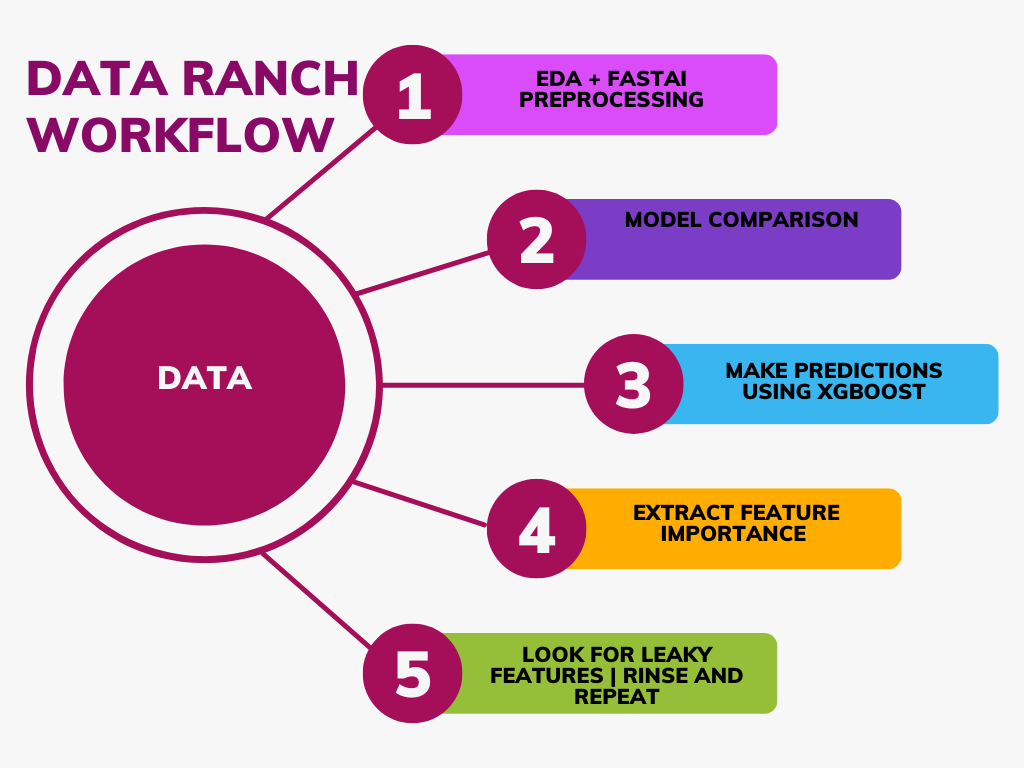

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.1 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'how-natural-disasters-impact-regions-labor-market'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/how-natural-disasters-impact-regions-labor-market
CSV!


In [12]:
df

Unnamed: 0  area_fips  year  qtr  qtrly_estabs  month1_emplvl  \
0            383      22063  2003    4          1400          17866   
1            346      22045  2003    3          1803          30620   
2            345      22045  2003    2          1810          29598   
3            344      22045  2003    1          1805          29188   
4            343      22043  2003    4           221           3145   
...          ...        ...   ...  ...           ...            ...   
1275         602      22045  2007    3          1936          34516   
1276         603      22045  2007    4          1932          34619   
1277         604      22047  2007    1           655          13749   
1278         591      22039  2007    4           630           8000   
1279         639      22063  2007    4          1771          22921   

      month2_emplvl  month3_emplvl  total_qtrly_wages  qtr_emp  \
0             17697          17696          110988687    53259   
1             30973          31483          223175185    93076   
2             29863          30518          219521478    89979   
3             29038          28976          210096622    87202   
4              3165           3214           21520968     9524   
...             ...            ...                ...      ...   
1275          34803          34764          345313304   104083   
1276          34756          34804          382402279   104179   
1277          13950          14131          176711226    41830   
1278           7966           7986           58828899    23952   
1279          23131          23215          194169593    69267   

      affected_county  after_2005Q3  affected_county_after_shock  
0                   1             0                            0  
1                   1             0                            0  
2                   1             0                            0  
3                   1             0                            0  
4                   0             0                            0  
...               ...           ...                          ...  
1275                1             1                            1  
1276                1             1                            1  
1277                0             1                            0  
1278                0             1                            0  
1279                1             1                            1  

[1280 rows x 13 columns]

In [13]:
df.isna().sum()

Unnamed: 0                     0
area_fips                      0
year                           0
qtr                            0
qtrly_estabs                   0
month1_emplvl                  0
month2_emplvl                  0
month3_emplvl                  0
total_qtrly_wages              0
qtr_emp                        0
affected_county                0
after_2005Q3                   0
affected_county_after_shock    0
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

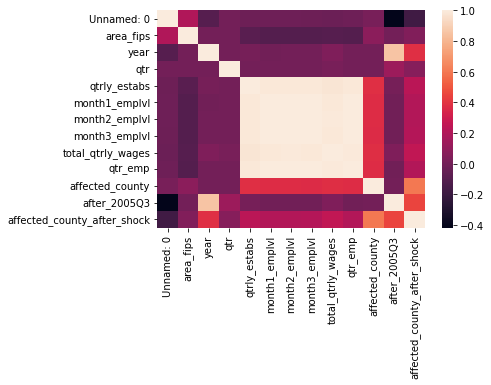

In [15]:
sns.heatmap(df.corr())

In [16]:
df.head().style.background_gradient(cmap = "inferno")

In [17]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [18]:
df.columns

Index(['Unnamed: 0', 'area_fips', 'year', 'qtr', 'qtrly_estabs',
       'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages',
       'qtr_emp', 'affected_county', 'after_2005Q3',
       'affected_county_after_shock'],
      dtype='object')

In [19]:
#remove 'Unnamed:0' as it's a leaky feature
del(df['Unnamed: 0'])

Target Variable: affected_county_after_shock
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  7%|▋         | 3/42 [00:00<00:01, 26.58it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02135610580444336}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03540921211242676}
{'Model': 'BayesianRidge', 'R-Squared': 0.5900923427497953, 'Adjusted R-Squared': 0.5716128991852368, 'RMSE': 0.2415445923266416, 'Time taken': 0.05572175979614258}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05668354034423828}
{'Model': 'DummyRegressor', 'R-Squared': -0.010720411663807994, 'Adjusted R-Squared': -0.05628567612406177, 'RMSE': 0.3792886279355736, 'Time taken': 0.037644386291503906}


 14%|█▍        | 6/42 [00:00<00:01, 24.70it/s]

{'Model': 'ElasticNet', 'R-Squared': -0.010720411663807994, 'Adjusted R-Squared': -0.05628567612406177, 'RMSE': 0.3792886, 'Time taken': 0.02301192283630371}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 838.2883911132812 but the user-supplied value was 838.2880859375.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0548858642578125}


 21%|██▏       | 9/42 [00:00<00:01, 17.01it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.15903496742248535}
{'Model': 'GammaRegressor', 'R-Squared': 0.420678920814311, 'Adjusted R-Squared': 0.3945619869165955, 'RMSE': 0.2871534040072031, 'Time taken': 0.03214836120605469}


 26%|██▌       | 11/42 [00:00<00:02, 10.59it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9523254010975025, 'Adjusted R-Squared': 0.9501761363928818, 'RMSE': 0.08237545517490306, 'Time taken': 0.31897807121276855}


 31%|███       | 13/42 [00:01<00:03,  8.46it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992869287, 'Adjusted R-Squared': 0.9999999992547821, 'RMSE': 1.0074436540093277e-05, 'Time taken': 0.20577573776245117}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992869287, 'Adjusted R-Squared': 0.9999999992547821, 'RMSE': 1.0074436624980453e-05, 'Time taken': 0.13699102401733398}


 38%|███▊      | 16/42 [00:01<00:03,  8.28it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.12990483394192054, 'Adjusted R-Squared': 0.09067923219340046, 'RMSE': 0.3519149212103313, 'Time taken': 0.22298240661621094}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9978044596912522, 'Adjusted R-Squared': 0.9977054804150381, 'RMSE': 0.017677669529663684, 'Time taken': 0.0435640811920166}
{'Model': 'KernelRidge', 'R-Squared': -8.588291757102692, 'Adjusted R-Squared': -9.020550811726174, 'RMSE': 1.1682208, 'Time taken': 0.10270118713378906}


 43%|████▎     | 18/42 [00:01<00:02,  9.23it/s]

{'Model': 'Lars', 'R-Squared': 0.21950295289872956, 'Adjusted R-Squared': 0.18431661061137716, 'RMSE': 0.33330354, 'Time taken': 0.06182241439819336}
{'Model': 'LarsCV', 'R-Squared': 0.2796637031965872, 'Adjusted R-Squared': 0.2471895258816792, 'RMSE': 0.32020047, 'Time taken': 0.08055806159973145}
{'Model': 'Lasso', 'R-Squared': -0.010720411663807994, 'Adjusted R-Squared': -0.05628567612406177, 'RMSE': 0.3792886, 'Time taken': 0.04491567611694336}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 838.2883911132812 but the user-supplied value was 838.2880859375.


 55%|█████▍    | 23/42 [00:02<00:01, 12.40it/s]

{'Model': 'LassoLars', 'R-Squared': -0.010720411663807994, 'Adjusted R-Squared': -0.05628567612406177, 'RMSE': 0.3792886, 'Time taken': 0.06371593475341797}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5902247820952092, 'Adjusted R-Squared': 0.5717513091568784, 'RMSE': 0.24150556, 'Time taken': 0.0648040771484375}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5904116932874606, 'Adjusted R-Squared': 0.5719466466733707, 'RMSE': 0.24145047, 'Time taken': 0.06707572937011719}
{'Model': 'LinearRegression', 'R-Squared': 0.592226245340701, 'Adjusted R-Squared': 0.5738430023027817, 'RMSE': 0.24091506, 'Time taken': 0.02817845344543457}


 60%|█████▉    | 25/42 [00:02<00:01, 12.22it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.11022621442006375, 'Adjusted R-Squared': 0.07011346179145994, 'RMSE': 0.35587223563242365, 'Time taken': 0.13258981704711914}
{'Model': 'MLPRegressor', 'R-Squared': 0.9613104170123595, 'Adjusted R-Squared': 0.9595662145006216, 'RMSE': 0.0742081, 'Time taken': 1.2248642444610596}


 64%|██████▍   | 27/42 [00:04<00:05,  2.82it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9993561787068059, 'Adjusted R-Squared': 0.9993271539763751, 'RMSE': 0.009572755605664259, 'Time taken': 0.7972762584686279}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.334611956869468, 'Adjusted R-Squared': 0.30461495492505863, 'RMSE': 0.3077455626556668, 'Time taken': 0.015959978103637695}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5862972912862165, 'Adjusted R-Squared': 0.567646759336005, 'RMSE': 0.24266016335188362, 'Time taken': 0.020839214324951172}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.332296009347708, 'Adjusted R-Squared': 0.3021945999330554, 'RMSE': 0.3082806665566761, 'Time taken': 0.016138792037963867}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4843440645142455, 'Adjusted R-Squared': 0.4610972805374286, 'RMSE': 0.2709157874032176, 'Time taken': 0.02763843536376953}


 79%|███████▊  | 33/42 [00:18<00:12,  1.41s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.20754716980979393, 'Adjusted R-Squared': -0.26198577172744875, 'RMSE': 0.41457809879416285, 'Time taken': 13.912028074264526}
{'Model': 'RANSACRegressor', 'R-Squared': -0.2075471698113207, 'Adjusted R-Squared': -0.26198577172904436, 'RMSE': 0.4145781, 'Time taken': 0.10631752014160156}


 90%|█████████ | 38/42 [00:18<00:02,  1.48it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2720184326171875}
{'Model': 'Ridge', 'R-Squared': 0.5901800893173974, 'Adjusted R-Squared': 0.5717046015407227, 'RMSE': 0.24151874, 'Time taken': 0.0173642635345459}
{'Model': 'RidgeCV', 'R-Squared': 0.590641862748361, 'Adjusted R-Squared': 0.5721871926263609, 'RMSE': 0.24138263133737253, 'Time taken': 0.03278374671936035}
{'Model': 'SGDRegressor', 'R-Squared': 0.5790663378730909, 'Adjusted R-Squared': 0.5600898203181892, 'RMSE': 0.24477165948712895, 'Time taken': 0.029300928115844727}
{'Model': 'SVR', 'R-Squared': 0.970828342708029, 'Adjusted R-Squared': 0.9695132270104401, 'RMSE': 0.06443693205909372, 'Time taken': 0.0554041862487793}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.592226245340701, 'Adjusted R-Squared': 0.5738430023027817, 'RMSE': 0.24091506, 'Time taken': 0.0404970645904541}
{'Model': 'TweedieRegressor', 'R-Squared': 0.4325546204845362, 'Adjusted R-Squ

100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999889872445, 'Adjusted R-Squared': 0.9999999884907679, 'RMSE': 3.959153e-05, 'Time taken': 0.49167633056640625}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992869287, 'Adjusted R-Squared': 0.9999999992547821, 'RMSE': 1.0074436624980453e-05, 'Time taken': 0.09680294990539551}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: affected_county_after_shock
affected_county_after_shock
Target Standard Deviation: 0.3393719785777105
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
RandomForestRegressor                        1.00       1.00  0.00        0.27
DecisionTreeRegressor                        1.00       1.00  0.00        0.06
BaggingRegressor                             1.00       1.0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.4174097776412964.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  3.959153e-05


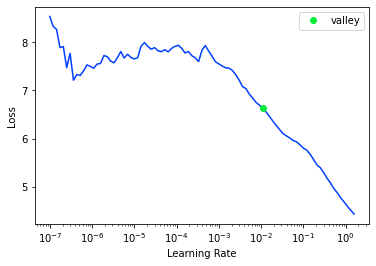

<Figure size 720x720 with 0 Axes>

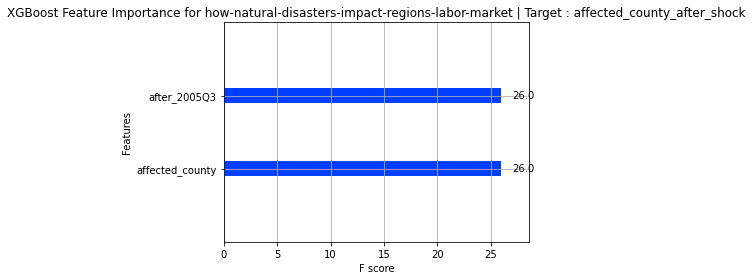

Target Variable: after_2005Q3
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8713051993626332, 'Adjusted R-Squared': 0.865503384579801, 'RMSE': 0.17910186360096805, 'Time taken': 0.02013111114501953}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03736543655395508}
{'Model': 'BayesianRidge', 'R-Squared': 0.7621215211823373, 'Adjusted R-Squared': 0.7513974913995738, 'RMSE': 0.24349899910555503, 'Time taken': 0.04071402549743652}


 10%|▉         | 4/42 [00:00<00:01, 24.00it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.060262441635131836}
{'Model': 'DummyRegressor', 'R-Squared': -0.0032177838996021446, 'Adjusted R-Squared': -0.04844481514097776, 'RMSE': 0.5000543564814081, 'Time taken': 0.031490325927734375}
{'Model': 'ElasticNet', 'R-Squared': -0.0032177838996021446, 'Adjusted R-Squared': -0.04844481514097776, 'RMSE': 0.50005436, 'Time taken': 0.015957355499267578}


 19%|█▉        | 8/42 [00:00<00:01, 26.24it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 840.1632080078125 but the user-supplied value was 840.1630859375.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05821728706359863}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.16820240020751953}
{'Model': 'GammaRegressor', 'R-Squared': 0.5889275093230886, 'Adjusted R-Squared': 0.5703955527761786, 'RMSE': 0.32009494172264064, 'Time taken': 0.0402684211730957}


 26%|██▌       | 11/42 [00:00<00:02, 11.69it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9379613466400267, 'Adjusted R-Squared': 0.9351645221033066, 'RMSE': 0.12435143038361722, 'Time taken': 0.27117156982421875}


 31%|███       | 13/42 [00:01<00:03,  8.21it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999175983609427, 'Adjusted R-Squared': 0.9999138835329524, 'RMSE': 0.004531975248399887, 'Time taken': 0.2990562915802002}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992922219, 'Adjusted R-Squared': 0.9999999992603139, 'RMSE': 1.3282143178707254e-05, 'Time taken': 0.1386246681213379}


 40%|████      | 17/42 [00:01<00:02, 10.53it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.7559820906657087, 'Adjusted R-Squared': 0.7449812832776873, 'RMSE': 0.24662122751514848, 'Time taken': 0.1337735652923584}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9768056320783594, 'Adjusted R-Squared': 0.975759984344187, 'RMSE': 0.07603453162872773, 'Time taken': 0.03775739669799805}
{'Model': 'KernelRidge', 'R-Squared': -7.71066351716293, 'Adjusted R-Squared': -8.103357364248145, 'RMSE': 1.4734833, 'Time taken': 0.06601572036743164}
{'Model': 'Lars', 'R-Squared': 0.7647999133286273, 'Adjusted R-Squared': 0.7541966307327868, 'RMSE': 0.24212427, 'Time taken': 0.030478239059448242}


 52%|█████▏    | 22/42 [00:01<00:01, 14.75it/s]

{'Model': 'LarsCV', 'R-Squared': 0.7619720425542283, 'Adjusted R-Squared': 0.7512412739808534, 'RMSE': 0.2435755, 'Time taken': 0.07767558097839355}
{'Model': 'Lasso', 'R-Squared': -0.0032177838996021446, 'Adjusted R-Squared': -0.04844481514097776, 'RMSE': 0.50005436, 'Time taken': 0.02816152572631836}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 840.1632080078125 but the user-supplied value was 840.1630859375.
{'Model': 'LassoLars', 'R-Squared': -0.0032177838996021446, 'Adjusted R-Squared': -0.04844481514097776, 'RMSE': 0.50005436, 'Time taken': 0.026132583618164062}
{'Model': 'LassoLarsCV', 'R-Squared': 0.7619720425542283, 'Adjusted R-Squared': 0.7512412739808534, 'RMSE': 0.2435755, 'Time taken': 0.07102680206298828}


 60%|█████▉    | 25/42 [00:01<00:01, 15.47it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.761968811989095, 'Adjusted R-Squared': 0.7512378977754887, 'RMSE': 0.24357715, 'Time taken': 0.051679134368896484}
{'Model': 'LinearRegression', 'R-Squared': 0.7647742267469566, 'Adjusted R-Squared': 0.7541697861494834, 'RMSE': 0.2421375, 'Time taken': 0.027179718017578125}
{'Model': 'LinearSVR', 'R-Squared': 0.7543152233426107, 'Adjusted R-Squared': 0.7432392702965809, 'RMSE': 0.2474621191362146, 'Time taken': 0.09186410903930664}


 64%|██████▍   | 27/42 [00:04<00:05,  2.84it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8719217247201514, 'Adjusted R-Squared': 0.866147704113273, 'RMSE': 0.17867234, 'Time taken': 2.214508056640625}
{'Model': 'NuSVR', 'R-Squared': 0.8831956445025894, 'Adjusted R-Squared': 0.8779298743777061, 'RMSE': 0.17062753739144504, 'Time taken': 0.1956193447113037}


 71%|███████▏  | 30/42 [00:04<00:02,  4.15it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7255492198079607, 'Adjusted R-Squared': 0.7131764387337294, 'RMSE': 0.2615482622890532, 'Time taken': 0.029723167419433594}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7621085254496172, 'Adjusted R-Squared': 0.7513839097936572, 'RMSE': 0.2435056504106816, 'Time taken': 0.04364180564880371}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5149225190081084, 'Adjusted R-Squared': -0.5832182063404412, 'RMSE': 0.6144899929836221, 'Time taken': 0.029041528701782227}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6571075515613279, 'Adjusted R-Squared': 0.641649285443191, 'RMSE': 0.2923469480875718, 'Time taken': 0.05934953689575195}


 79%|███████▊  | 33/42 [00:22<00:18,  2.06s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.896296296098618, 'Adjusted R-Squared': -0.9817850635456871, 'RMSE': 0.687499999964166, 'Time taken': 17.650123596191406}
RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 83%|████████▎ | 35/42 [00:22<00:10,  1.49s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.3065202236175537}
{'Model': 'Ridge', 'R-Squared': 0.7631706966445642, 'Adjusted R-Squared': 0.7524939657555896, 'RMSE': 0.24296142, 'Time taken': 0.020210981369018555}
{'Model': 'RidgeCV', 'R-Squared': 0.761581877453187, 'Adjusted R-Squared': 0.7508335194695192, 'RMSE': 0.24377503977337986, 'Time taken': 0.03573918342590332}
{'Model': 'SGDRegressor', 'R-Squared': 0.7608293828702366, 'Adjusted R-Squared': 0.7500471009504521, 'RMSE': 0.24415943773813256, 'Time taken': 0.027860403060913086}


 90%|█████████ | 38/42 [00:22<00:03,  1.08it/s]

{'Model': 'SVR', 'R-Squared': 0.8691383388961315, 'Adjusted R-Squared': 0.8632388377807931, 'RMSE': 0.18060335695189242, 'Time taken': 0.11685061454772949}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.7647742267469566, 'Adjusted R-Squared': 0.7541697861494834, 'RMSE': 0.2421375, 'Time taken': 0.01992344856262207}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6002023199109552, 'Adjusted R-Squared': 0.5821786540053016, 'RMSE': 0.31567467276821815, 'Time taken': 0.048662424087524414}


100%|██████████| 42/42 [00:23<00:00,  1.79it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.999999986312808, 'Adjusted R-Squared': 0.9999999856957624, 'RMSE': 5.8408597e-05, 'Time taken': 0.49564242362976074}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992922219, 'Adjusted R-Squared': 0.9999999992603139, 'RMSE': 1.3282143178707254e-05, 'Time taken': 0.05995345115661621}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: after_2005Q3
after_2005Q3
Target Standard Deviation: 0.49689185155926646
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
DecisionTreeRegressor                        1.00       1.00  0.00        0.06
RandomForestRegressor                        1.00       1.00  0.00        0.31
ExtraTreeRegressor                           1.00       1.00  0.00        0.06
ExtraTreesRegressor                          1.00       1.00  0.00        0.17
BaggingRe

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.4217920303344727.
Better model found at epoch 1 with _rmse value: 1.047881007194519.
Better model found at epoch 2 with _rmse value: 0.9240165948867798.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       1       1.00
2       2       2.00
3       2       2.00
4       2       2.00
XGBoost RMSE:  5.8408597e-05


<Figure size 432x288 with 0 Axes>

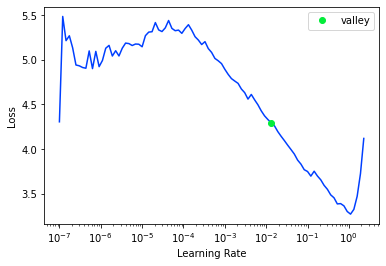

<Figure size 720x720 with 0 Axes>

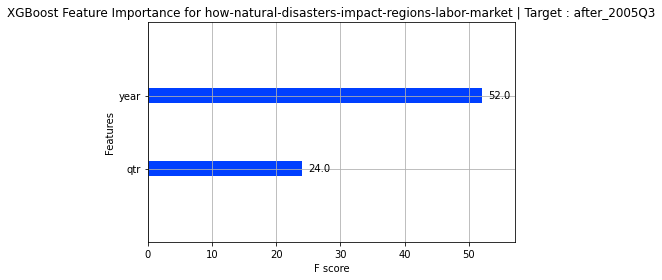

Target Variable: affected_county
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  7%|▋         | 3/42 [00:00<00:01, 29.87it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6474100094374176, 'Adjusted R-Squared': 0.6315145590432028, 'RMSE': 0.2788039297072725, 'Time taken': 0.026131629943847656}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9836987818383167, 'Adjusted R-Squared': 0.9829638908556179, 'RMSE': 0.059947894041408996, 'Time taken': 0.0491032600402832}
{'Model': 'BayesianRidge', 'R-Squared': 0.5204430611587971, 'Adjusted R-Squared': 0.49882369096513635, 'RMSE': 0.32515017405333735, 'Time taken': 0.02450871467590332}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.033315181732177734}
{'Model': 'DummyRegressor', 'R-Squared': -0.0017303433001107926, 'Adjusted R-Squared': -0.046890317793148784, 'RMSE': 0.4699366490300182, 'Time taken': 0.02514338493347168}
{'Model': 'ElasticNet', 'R-Squared': -0.0017303433001107926, 'Adjusted R-Squared': -0.046890317793148784, 'RMSE': 0.46993664, 'Time taken': 0.03605365753173828}


 17%|█▋        | 7/42 [00:00<00:01, 21.84it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 782.9669799804688 but the user-supplied value was 782.966796875.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.946843853820598, 'Adjusted R-Squared': 0.9444474701813627, 'RMSE': 0.10825317547305482, 'Time taken': 0.01758289337158203}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9984194905869325, 'Adjusted R-Squared': 0.9983482381133926, 'RMSE': 0.018666480653835107, 'Time taken': 0.164503812789917}


 24%|██▍       | 10/42 [00:00<00:01, 17.29it/s]

{'Model': 'GammaRegressor', 'R-Squared': 0.3534264061647623, 'Adjusted R-Squared': 0.32427759660661626, 'RMSE': 0.377548616499399, 'Time taken': 0.039867401123046875}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -16.092426469860467, 'Adjusted R-Squared': -16.862986679567292, 'RMSE': 1.9411797907586523, 'Time taken': 0.24601531028747559}


 29%|██▊       | 12/42 [00:01<00:03,  8.19it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9297352158967189, 'Adjusted R-Squared': 0.9265675412035382, 'RMSE': 0.12446084902786897, 'Time taken': 0.320972204208374}


 33%|███▎      | 14/42 [00:01<00:04,  6.13it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9875627268816844, 'Adjusted R-Squared': 0.987002030142744, 'RMSE': 0.0523632371044641, 'Time taken': 0.42030763626098633}
{'Model': 'HuberRegressor', 'R-Squared': 0.1679525919015249, 'Adjusted R-Squared': 0.13044225792987219, 'RMSE': 0.428290002849986, 'Time taken': 0.10757112503051758}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7391805094130676, 'Adjusted R-Squared': 0.7274222536898862, 'RMSE': 0.23979157616563598, 'Time taken': 0.02739715576171875}


 38%|███▊      | 16/42 [00:01<00:03,  6.88it/s]

{'Model': 'KernelRidge', 'R-Squared': -7.266085395517276, 'Adjusted R-Squared': -7.638736786298793, 'RMSE': 1.349938, 'Time taken': 0.17398500442504883}
{'Model': 'Lars', 'R-Squared': 0.5209079967414747, 'Adjusted R-Squared': 0.49930958675850834, 'RMSE': 0.3249925, 'Time taken': 0.08995437622070312}


 48%|████▊     | 20/42 [00:02<00:02,  8.17it/s]

{'Model': 'LarsCV', 'R-Squared': 0.3521176732639274, 'Adjusted R-Squared': 0.3229098634520552, 'RMSE': 0.37793052, 'Time taken': 0.11200571060180664}
{'Model': 'Lasso', 'R-Squared': -0.0017303433001107926, 'Adjusted R-Squared': -0.046890317793148784, 'RMSE': 0.46993664, 'Time taken': 0.06309318542480469}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 782.9669799804688 but the user-supplied value was 782.966796875.


 57%|█████▋    | 24/42 [00:02<00:01, 11.27it/s]

{'Model': 'LassoLars', 'R-Squared': -0.0017303433001107926, 'Adjusted R-Squared': -0.046890317793148784, 'RMSE': 0.46993664, 'Time taken': 0.03301119804382324}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5230265324908561, 'Adjusted R-Squared': 0.5015236302670831, 'RMSE': 0.32427317, 'Time taken': 0.0753636360168457}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5209079967414747, 'Adjusted R-Squared': 0.49930958675850834, 'RMSE': 0.3249925, 'Time taken': 0.047788381576538086}
{'Model': 'LinearRegression', 'R-Squared': 0.5208955934140855, 'Adjusted R-Squared': 0.49929662426472043, 'RMSE': 0.3249967, 'Time taken': 0.06050300598144531}
{'Model': 'LinearSVR', 'R-Squared': 0.21609872884807313, 'Adjusted R-Squared': 0.1807589174436829, 'RMSE': 0.4157139378087115, 'Time taken': 0.13349556922912598}


 62%|██████▏   | 26/42 [00:04<00:06,  2.35it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7084220391484093, 'Adjusted R-Squared': 0.695277131077231, 'RMSE': 0.25353694, 'Time taken': 2.2921535968780518}


 67%|██████▋   | 28/42 [00:05<00:04,  2.91it/s]

{'Model': 'NuSVR', 'R-Squared': 0.6587627988147559, 'Adjusted R-Squared': 0.6433791544990276, 'RMSE': 0.2742787027901847, 'Time taken': 0.26914000511169434}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.34465324486642224, 'Adjusted R-Squared': 0.31510892393826906, 'RMSE': 0.38010140758776517, 'Time taken': 0.025462627410888672}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.523235185758146, 'Adjusted R-Squared': 0.5017416900341279, 'RMSE': 0.3242022312284335, 'Time taken': 0.037113189697265625}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.4341733753089976, 'Adjusted R-Squared': -0.49882873239260017, 'RMSE': 0.5622956568730434, 'Time taken': 0.021467924118041992}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3900038772567087, 'Adjusted R-Squared': 0.3625040520510685, 'RMSE': 0.366713956228385, 'Time taken': 0.030071735382080078}


 79%|███████▊  | 33/42 [00:20<00:14,  1.66s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.4883720951562298, 'Adjusted R-Squared': -0.555470837150978, 'RMSE': 0.5728219622799333, 'Time taken': 14.81989336013794}
{'Model': 'RANSACRegressor', 'R-Squared': -0.4883720930232558, 'Adjusted R-Squared': -0.5554708349218453, 'RMSE': 0.572822, 'Time taken': 0.15769290924072266}


 88%|████████▊ | 37/42 [00:20<00:04,  1.17it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9939933554817276, 'Adjusted R-Squared': 0.993722564130494, 'RMSE': 0.036389816570024096, 'Time taken': 0.38263511657714844}
{'Model': 'Ridge', 'R-Squared': 0.5224895487736868, 'Adjusted R-Squared': 0.5009624382675825, 'RMSE': 0.32445565, 'Time taken': 0.014770269393920898}
{'Model': 'RidgeCV', 'R-Squared': 0.5224898865523316, 'Adjusted R-Squared': 0.5009627912739532, 'RMSE': 0.3244555356893514, 'Time taken': 0.03928732872009277}
{'Model': 'SGDRegressor', 'R-Squared': 0.5076503286316889, 'Adjusted R-Squared': 0.4854542368896748, 'RMSE': 0.3294585080206958, 'Time taken': 0.06360387802124023}


 93%|█████████▎| 39/42 [00:20<00:01,  1.59it/s]

{'Model': 'SVR', 'R-Squared': 0.6947984152040003, 'Adjusted R-Squared': 0.6810393273648363, 'RMSE': 0.25939242744106183, 'Time taken': 0.08349108695983887}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5208955934140855, 'Adjusted R-Squared': 0.49929662426472043, 'RMSE': 0.3249967, 'Time taken': 0.015332221984863281}
{'Model': 'TweedieRegressor', 'R-Squared': 0.36253758661436686, 'Adjusted R-Squared': 0.33379952699452264, 'RMSE': 0.3748790688105073, 'Time taken': 0.02435922622680664}


100%|██████████| 42/42 [00:21<00:00,  1.94it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9900442817288126, 'Adjusted R-Squared': 0.989595458364128, 'RMSE': 0.046848986, 'Time taken': 0.5858345031738281}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9837820444697087, 'Adjusted R-Squared': 0.9830509071302284, 'RMSE': 0.059794598458781566, 'Time taken': 0.11856198310852051}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: affected_county
affected_county
Target Standard Deviation: 0.461913030191764
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
DecisionTreeRegressor                        1.00       1.00  0.00        0.03
ExtraTreesRegressor                          1.00       1.00  0.02        0.16
RandomForestRegressor                        0.99       0.99  0.04        0.38
XGBRegressor                                 0.99       0.99  0.05        0.59
HistGradie

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.2104912996292114.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.00
2       1       1.09
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.046771046


<Figure size 432x288 with 0 Axes>

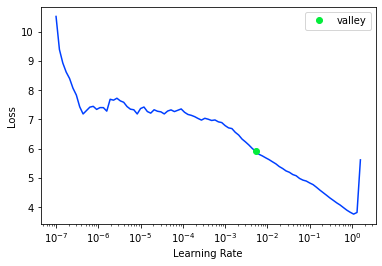

<Figure size 720x720 with 0 Axes>

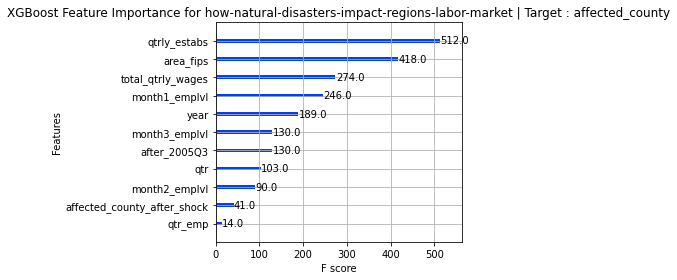

Target Variable: qtr_emp
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages']
11
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  7%|▋         | 3/42 [00:00<00:03, 12.59it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9955741773502479, 'Adjusted R-Squared': 0.9953746525586608, 'RMSE': 11654.94384566621, 'Time taken': 0.15106630325317383}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9996729196175951, 'Adjusted R-Squared': 0.9996581741905195, 'RMSE': 3168.403105623803, 'Time taken': 0.0775139331817627}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999992, 'Adjusted R-Squared': 0.9999999999999992, 'RMSE': 0.004878538506703001, 'Time taken': 0.02945566177368164}


 19%|█▉        | 8/42 [00:00<00:01, 18.98it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9982803204753327, 'Adjusted R-Squared': 0.9982027939393845, 'RMSE': 7265.022138967472, 'Time taken': 0.10084199905395508}
{'Model': 'DummyRegressor', 'R-Squared': -0.0170563622612514, 'Adjusted R-Squared': -0.06290726383860301, 'RMSE': 176679.31, 'Time taken': 0.018352270126342773}
{'Model': 'ElasticNet', 'R-Squared': 0.9882919885097514, 'Adjusted R-Squared': 0.9877641683196172, 'RMSE': 18956.352, 'Time taken': 0.014896869659423828}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed -62.71212387084961 but the user-supplied value was -62.71214294433594.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.999641178128401, 'Adjusted R-Squared': 0.9996250017325503, 'RMSE': 3318.5826281947916, 'Time taken': 0.03409934043884277}


 24%|██▍       | 10/42 [00:00<00:03,  9.07it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999589691695399, 'Adjusted R-Squared': 0.9999571194189864, 'RMSE': 1122.1950157841468, 'Time taken': 0.41438889503479004}
{'Model': 'GammaRegressor', 'R-Squared': -1.197748214889641, 'Adjusted R-Squared': -1.2968270278559775, 'RMSE': 259718.05981254883, 'Time taken': 0.033371686935424805}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9491642645279271, 'Adjusted R-Squared': 0.9468724895681205, 'RMSE': 39500.05837643354, 'Time taken': 0.2294628620147705}


 29%|██▊       | 12/42 [00:01<00:04,  6.26it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9998868902128595, 'Adjusted R-Squared': 0.9998817910011442, 'RMSE': 1863.2162980715318, 'Time taken': 0.2930183410644531}


 33%|███▎      | 14/42 [00:02<00:06,  4.03it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9985418970385477, 'Adjusted R-Squared': 0.9984761628886462, 'RMSE': 6689.709791493945, 'Time taken': 0.6832656860351562}
{'Model': 'HuberRegressor', 'R-Squared': 0.999999995875388, 'Adjusted R-Squared': 0.9999999956894424, 'RMSE': 11.251352515849964, 'Time taken': 0.19562816619873047}


 43%|████▎     | 18/42 [00:02<00:03,  6.76it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9949690275968106, 'Adjusted R-Squared': 0.9947422214638799, 'RMSE': 12426.224, 'Time taken': 0.039283037185668945}
{'Model': 'KernelRidge', 'R-Squared': 0.7820130532963757, 'Adjusted R-Squared': 0.7721857729121959, 'RMSE': 81795.31, 'Time taken': 0.06392860412597656}
{'Model': 'Lars', 'R-Squared': 0.9999999959077325, 'Adjusted R-Squared': 0.999999995723245, 'RMSE': 11.20715, 'Time taken': 0.030989646911621094}
{'Model': 'LarsCV', 'R-Squared': 0.9999999980125677, 'Adjusted R-Squared': 0.9999999979229703, 'RMSE': 7.8101497, 'Time taken': 0.08290314674377441}


 48%|████▊     | 20/42 [00:02<00:02,  7.54it/s]

{'Model': 'Lasso', 'R-Squared': 0.999980185447471, 'Adjusted R-Squared': 0.9999792921684636, 'RMSE': 779.83966, 'Time taken': 0.06432604789733887}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed -62.71212387084961 but the user-supplied value was -62.71214294433594.
{'Model': 'LassoLars', 'R-Squared': 0.9999999517418636, 'Adjusted R-Squared': 0.9999999495662919, 'RMSE': 38.48562, 'Time taken': 0.016887664794921875}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999980125677, 'Adjusted R-Squared': 0.9999999979229703, 'RMSE': 7.8101497, 'Time taken': 0.03266334533691406}


 57%|█████▋    | 24/42 [00:02<00:01, 11.73it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999979648971, 'Adjusted R-Squared': 0.9999999978731507, 'RMSE': 7.9032617, 'Time taken': 0.04200267791748047}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999999539, 'Adjusted R-Squared': 0.9999999999999518, 'RMSE': 0.03758418, 'Time taken': 0.02829146385192871}
{'Model': 'LinearSVR', 'R-Squared': -0.3499865918548788, 'Adjusted R-Squared': -0.410846643127025, 'RMSE': 203553.1883970994, 'Time taken': 0.02726006507873535}


 67%|██████▋   | 28/42 [00:05<00:03,  3.90it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.33750785710137854, 'Adjusted R-Squared': -0.3978053424625063, 'RMSE': 202610.23, 'Time taken': 2.0091042518615723}
{'Model': 'NuSVR', 'R-Squared': -0.12338465438877688, 'Adjusted R-Squared': -0.17402904454564805, 'RMSE': 185685.25799649017, 'Time taken': 0.13972759246826172}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9999595159266023, 'Adjusted R-Squared': 0.9999576908249327, 'RMSE': 1114.6930251502997, 'Time taken': 0.018904685974121094}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999763352209041, 'Adjusted R-Squared': 0.9999752683661088, 'RMSE': 852.2448966392194, 'Time taken': 0.024552583694458008}


 71%|███████▏  | 30/42 [00:05<00:02,  4.86it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9998371955749651, 'Adjusted R-Squared': 0.9998298560312135, 'RMSE': 2235.3538698803204, 'Time taken': 0.11607742309570312}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7387347670685285, 'Adjusted R-Squared': 0.7269564164035851, 'RMSE': 89547.60862456688, 'Time taken': 0.1011204719543457}


 76%|███████▌  | 32/42 [00:40<00:50,  5.05s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.18264654844031925, 'Adjusted R-Squared': -0.23596258136180914, 'RMSE': 190520.04095983045, 'Time taken': 34.83928060531616}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999999482, 'Adjusted R-Squared': 0.9999999999999458, 'RMSE': 0.03990934, 'Time taken': 0.06074333190917969}


 81%|████████  | 34/42 [00:40<00:29,  3.71s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9997985132064463, 'Adjusted R-Squared': 0.9997894297854254, 'RMSE': 2486.7748969795516, 'Time taken': 0.6922075748443604}
{'Model': 'Ridge', 'R-Squared': 0.9999888760376092, 'Adjusted R-Squared': 0.9999883745475014, 'RMSE': 584.30945, 'Time taken': 0.022793292999267578}
{'Model': 'RidgeCV', 'R-Squared': 0.999999865960704, 'Adjusted R-Squared': 0.9999998599179488, 'RMSE': 64.14004362152976, 'Time taken': 0.04865145683288574}


 93%|█████████▎| 39/42 [00:41<00:05,  1.73s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.9999995380547796, 'Adjusted R-Squared': 0.9999995172293803, 'RMSE': 119.07166345833447, 'Time taken': 0.19173169136047363}
{'Model': 'SVR', 'R-Squared': -0.1821794272297268, 'Adjusted R-Squared': -0.23547440140811626, 'RMSE': 190482.4114829914, 'Time taken': 0.09830641746520996}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999539, 'Adjusted R-Squared': 0.9999999999999518, 'RMSE': 0.03758418, 'Time taken': 0.014908075332641602}
{'Model': 'TweedieRegressor', 'R-Squared': 0.967862553019729, 'Adjusted R-Squared': 0.9664137336886512, 'RMSE': 31406.45140194974, 'Time taken': 0.029950857162475586}


100%|██████████| 42/42 [00:42<00:00,  1.00s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9989293839545593, 'Adjusted R-Squared': 0.9988811184771009, 'RMSE': 5732.3154, 'Time taken': 0.604102373123169}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9994912647822245, 'Adjusted R-Squared': 0.9994683299978165, 'RMSE': 3951.4735886312947, 'Time taken': 0.1221609115600586}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: qtr_emp
qtr_emp
Target Standard Deviation: 143471.046875
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
BayesianRidge                                1.00       1.00      0.00   
LinearRegression                             1.00       1.00      0.04   
TransformedTargetRegressor                   1.00       1.00      0.04   
RANSACRegressor                              1.00       1.00      0.04   
LassoLarsCV                                  1.00       1.00     

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 204064.328125.
Better model found at epoch 1 with _rmse value: 203802.296875.
Better model found at epoch 2 with _rmse value: 199341.421875.
Better model found at epoch 3 with _rmse value: 178820.875.
Better model found at epoch 4 with _rmse value: 105292.2265625.
No improvement since epoch 4: early stopping


<Figure size 432x288 with 0 Axes>

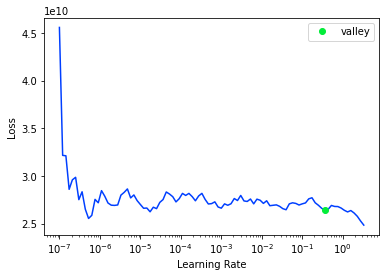

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0  33450.00   33374.67
1  23077.00   23146.96
2  38967.00   38863.24
3   9366.00    9241.05
4 153603.00  150790.78
XGBoost RMSE:  5732.198


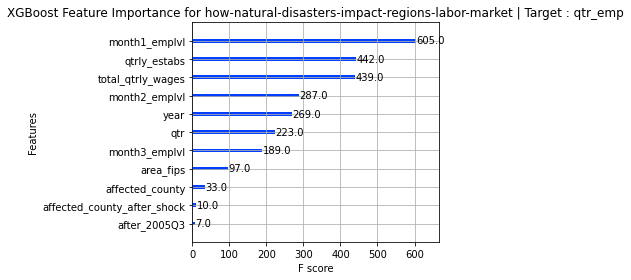

Target Variable: total_qtrly_wages
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'qtr_emp']
11
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9839653432834007, 'Adjusted R-Squared': 0.9832424694150294, 'RMSE': 56204766.55381294, 'Time taken': 0.09499073028564453}


  5%|▍         | 2/42 [00:00<00:03, 11.49it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9959611555287698, 'Adjusted R-Squared': 0.995779076474739, 'RMSE': 28207973.03455848, 'Time taken': 0.07874274253845215}
{'Model': 'BayesianRidge', 'R-Squared': -0.0015102936843263137, 'Adjusted R-Squared': -0.04666034790780005, 'RMSE': 444192297.79889107, 'Time taken': 0.029885053634643555}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9951063406807517, 'Adjusted R-Squared': 0.9948857248917692, 'RMSE': 31049898.221945807, 'Time taken': 0.03877830505371094}
{'Model': 'DummyRegressor', 'R-Squared': -0.001510267062964532, 'Adjusted R-Squared': -0.04666032008629495, 'RMSE': 444192300.0, 'Time taken': 0.023169279098510742}


 14%|█▍        | 6/42 [00:00<00:01, 20.05it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.9691161893547079, 'Adjusted R-Squared': 0.9677238864157808, 'RMSE': 78002540.0, 'Time taken': 0.053676605224609375}
{'Model': 'ElasticNetCV', 'R-Squared': -0.0014890586079527868, 'Adjusted R-Squared': -0.046638155512409796, 'RMSE': 444187600.0, 'Time taken': 0.15407514572143555}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9930068095503988, 'Adjusted R-Squared': 0.9926915427678348, 'RMSE': 37117694.49562774, 'Time taken': 0.03309154510498047}


 21%|██▏       | 9/42 [00:00<00:03,  8.62it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9968478516390479, 'Adjusted R-Squared': 0.9967057465899886, 'RMSE': 24919919.78515364, 'Time taken': 0.40704965591430664}
{'Model': 'GammaRegressor', 'R-Squared': -1.0935402076920804, 'Adjusted R-Squared': -1.1879211186945926, 'RMSE': 642220209.7909019, 'Time taken': 0.029458999633789062}


 26%|██▌       | 11/42 [00:01<00:03,  8.30it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.8792120910049612, 'Adjusted R-Squared': 0.8737667344519062, 'RMSE': 154260610.7705767, 'Time taken': 0.23016929626464844}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9967151432888972, 'Adjusted R-Squared': 0.9965670554863475, 'RMSE': 25439087.549913537, 'Time taken': 0.28047919273376465}


 38%|███▊      | 16/42 [00:02<00:03,  7.21it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9948431749165403, 'Adjusted R-Squared': 0.994610695097204, 'RMSE': 31873849.326635852, 'Time taken': 0.4346764087677002}
{'Model': 'HuberRegressor', 'R-Squared': 0.04643156548723015, 'Adjusted R-Squared': 0.0034428245870642415, 'RMSE': 433430279.7877637, 'Time taken': 0.0495448112487793}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9856164271448966, 'Adjusted R-Squared': 0.9849679873850354, 'RMSE': 53232480.0, 'Time taken': 0.0399622917175293}
{'Model': 'KernelRidge', 'R-Squared': 0.6577702907703831, 'Adjusted R-Squared': 0.6423419022395396, 'RMSE': 259658290.0, 'Time taken': 0.07042551040649414}


 43%|████▎     | 18/42 [00:02<00:02,  8.47it/s]

{'Model': 'Lars', 'R-Squared': -25242.975861258165, 'Adjusted R-Squared': -26381.023953364067, 'RMSE': 70521600000.0, 'Time taken': 0.03781723976135254}
{'Model': 'LarsCV', 'R-Squared': 0.8606958883257075, 'Adjusted R-Squared': 0.854415784930555, 'RMSE': 165662910.0, 'Time taken': 0.0783834457397461}
{'Model': 'Lasso', 'R-Squared': 0.9850669296371996, 'Adjusted R-Squared': 0.9843937174487126, 'RMSE': 54239772.0, 'Time taken': 0.06235313415527344}


 52%|█████▏    | 22/42 [00:02<00:02,  9.78it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9851990081682878, 'Adjusted R-Squared': 0.9845317503398089, 'RMSE': 53999376.0, 'Time taken': 0.20215058326721191}
{'Model': 'LassoLars', 'R-Squared': 0.9858565624152894, 'Adjusted R-Squared': 0.9852189484258147, 'RMSE': 52786250.0, 'Time taken': 0.03272843360900879}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9858596879750987, 'Adjusted R-Squared': 0.9852222148920089, 'RMSE': 52780416.0, 'Time taken': 0.06870579719543457}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9858566799261542, 'Adjusted R-Squared': 0.9852190712343005, 'RMSE': 52786028.0, 'Time taken': 0.040552377700805664}
{'Model': 'LinearRegression', 'R-Squared': 0.9858560688455547, 'Adjusted R-Squared': 0.9852184326049854, 'RMSE': 52787172.0, 'Time taken': 0.0231626033782959}
{'Model': 'LinearSVR', 'R-Squared': -0.2731647638868413, 'Adjusted R-Squared': -0.33056153602928107, 'RMSE': 500824562.4727145, 'Time taken': 0.023354768753051758}


 67%|██████▋   | 28/42 [00:02<00:01, 11.84it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2731671804713196, 'Adjusted R-Squared': -0.33056406155814155, 'RMSE': 500825020.0, 'Time taken': 0.170088529586792}
{'Model': 'NuSVR', 'R-Squared': -0.049663341970242136, 'Adjusted R-Squared': -0.09698423033775305, 'RMSE': 454745416.2726953, 'Time taken': 0.14141345024108887}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9821814435816534, 'Adjusted R-Squared': 0.9813781480054165, 'RMSE': 59248801.97654622, 'Time taken': 0.019381046295166016}


 71%|███████▏  | 30/42 [00:03<00:01, 10.92it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9853491794974684, 'Adjusted R-Squared': 0.984688691687928, 'RMSE': 53724735.83906687, 'Time taken': 0.05204582214355469}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.27076092207606384, 'Adjusted R-Squared': -0.32804932430080447, 'RMSE': 500351539.7101222, 'Time taken': 0.16507172584533691}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7955624800168558, 'Adjusted R-Squared': 0.7863460344438452, 'RMSE': 200689022.18711397, 'Time taken': 0.1008908748626709}


 79%|███████▊  | 33/42 [00:39<00:37,  4.15s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.13154231539835215, 'Adjusted R-Squared': -0.1825544689613927, 'RMSE': 472148609.25827384, 'Time taken': 36.01457762718201}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9604277423449291, 'Adjusted R-Squared': 0.9586437471227742, 'RMSE': 88295540.0, 'Time taken': 0.13190054893493652}


 88%|████████▊ | 37/42 [00:40<00:10,  2.05s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9964966964149439, 'Adjusted R-Squared': 0.9963387605975847, 'RMSE': 26271338.5916199, 'Time taken': 0.6361663341522217}
{'Model': 'Ridge', 'R-Squared': 0.9852215456950509, 'Adjusted R-Squared': 0.9845553039026147, 'RMSE': 53958244.0, 'Time taken': 0.0197603702545166}
{'Model': 'RidgeCV', 'R-Squared': 0.9856016054786736, 'Adjusted R-Squared': 0.9849524975289417, 'RMSE': 53259900.35973452, 'Time taken': 0.050072669982910156}
{'Model': 'SGDRegressor', 'R-Squared': 0.9839744608231028, 'Adjusted R-Squared': 0.9832519979913574, 'RMSE': 56188784.856580555, 'Time taken': 0.06285643577575684}


 93%|█████████▎| 39/42 [00:40<00:04,  1.44s/it]

{'Model': 'SVR', 'R-Squared': -0.13630980759612155, 'Adjusted R-Squared': -0.18753688908611066, 'RMSE': 473142208.34061396, 'Time taken': 0.12281966209411621}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9858560688455547, 'Adjusted R-Squared': 0.9852184326049854, 'RMSE': 52787172.0, 'Time taken': 0.019933462142944336}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9453847697393708, 'Adjusted R-Squared': 0.9429226077194244, 'RMSE': 103729002.00758512, 'Time taken': 0.03993368148803711}


100%|██████████| 42/42 [00:41<00:00,  1.02it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9951287176188807, 'Adjusted R-Squared': 0.9949091106262892, 'RMSE': 30978828.0, 'Time taken': 0.6146693229675293}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9953449299697815, 'Adjusted R-Squared': 0.9951350702553045, 'RMSE': 30283524.916525472, 'Time taken': 0.12122416496276855}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: total_qtrly_wages
total_qtrly_wages
Target Standard Deviation: 466994944.0
                               Adjusted R-Squared  R-Squared           RMSE  \
Model                                                                         
ExtraTreesRegressor                          1.00       1.00    24919919.79   
GradientBoostingRegressor                    1.00       1.00    25439087.55   
RandomForestRegressor                        1.00       1.00    26271338.59   
BaggingRegressor                             1.00       1.00    28207973.03   
LGBMRegressor 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 500825024.0.
Better model found at epoch 1 with _rmse value: 500824896.0.
Better model found at epoch 2 with _rmse value: 500821888.0.
Better model found at epoch 3 with _rmse value: 500795008.0.
Better model found at epoch 4 with _rmse value: 500627904.0.
Better model found at epoch 5 with _rmse value: 500514432.0.
Better model found at epoch 6 with _rmse value: 500405408.0.
Better model found at epoch 7 with _rmse value: 500262208.0.
Better model found at epoch 8 with _rmse value: 500202400.0.
No improvement since epoch 8: early stopping


<Figure size 432x288 with 0 Axes>

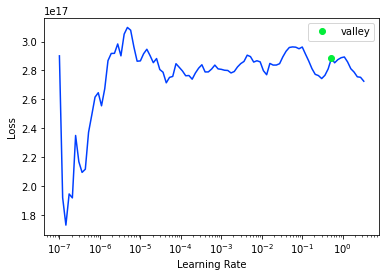

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
         actual     predicted
0   26451334.00   27829482.00
1 1963486848.00 1912717568.00
2   56932344.00   56371448.00
3  117382448.00  116363184.00
4   20695264.00   21918224.00
XGBoost RMSE:  30768438.0


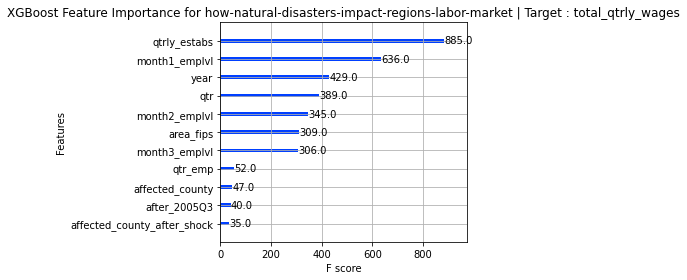

Target Variable: month3_emplvl
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'total_qtrly_wages', 'qtr_emp']
11
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  5%|▍         | 2/42 [00:00<00:02, 16.16it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.99201703425586, 'Adjusted R-Squared': 0.9916571464559192, 'RMSE': 4702.64543137251, 'Time taken': 0.05235600471496582}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9997590041560779, 'Adjusted R-Squared': 0.9997481395893437, 'RMSE': 817.0805618605259, 'Time taken': 0.07084465026855469}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999887, 'Adjusted R-Squared': 0.9999999999999881, 'RMSE': 0.005588519381096471, 'Time taken': 0.036435604095458984}


 10%|▉         | 4/42 [00:00<00:02, 17.52it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9995402428083606, 'Adjusted R-Squared': 0.9995195160497211, 'RMSE': 1128.5592585238933, 'Time taken': 0.06745314598083496}
{'Model': 'DummyRegressor', 'R-Squared': -0.0010971157355277317, 'Adjusted R-Squared': -0.04622854308426061, 'RMSE': 52662.105, 'Time taken': 0.04301333427429199}
{'Model': 'ElasticNet', 'R-Squared': 0.9872927177522544, 'Adjusted R-Squared': 0.9867198484705937, 'RMSE': 5933.165, 'Time taken': 0.017907142639160156}


 17%|█▋        | 7/42 [00:00<00:02, 15.05it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.17416770915762114, 'Adjusted R-Squared': 0.13693756489833353, 'RMSE': 47830.625, 'Time taken': 0.1564464569091797}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9958286718258771, 'Adjusted R-Squared': 0.9956406201458962, 'RMSE': 3399.3609544203305, 'Time taken': 0.031671762466430664}


 21%|██▏       | 9/42 [00:00<00:04,  8.23it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9998491207818571, 'Adjusted R-Squared': 0.9998423188498916, 'RMSE': 646.5093569000945, 'Time taken': 0.4155611991882324}
{'Model': 'GammaRegressor', 'R-Squared': -1.139409917349048, 'Adjusted R-Squared': -1.2358587250983906, 'RMSE': 76985.1755929307, 'Time taken': 0.018048763275146484}


 26%|██▌       | 11/42 [00:01<00:03,  8.30it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.963575632869148, 'Adjusted R-Squared': 0.9619335507443966, 'RMSE': 10045.142677586045, 'Time taken': 0.21615266799926758}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9997644607534901, 'Adjusted R-Squared': 0.9997538421809016, 'RMSE': 807.7774832151473, 'Time taken': 0.27747249603271484}


 33%|███▎      | 14/42 [00:01<00:05,  5.35it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9995356626850128, 'Adjusted R-Squared': 0.9995147294454028, 'RMSE': 1134.1667086301213, 'Time taken': 0.43203091621398926}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999160905998182, 'Adjusted R-Squared': 0.9999123077989903, 'RMSE': 482.1313930430405, 'Time taken': 0.14192581176757812}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9906267137505445, 'Adjusted R-Squared': 0.9902041475671673, 'RMSE': 5095.7256, 'Time taken': 0.03598332405090332}


 45%|████▌     | 19/42 [00:02<00:02,  9.82it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.7038070554772984, 'Adjusted R-Squared': 0.69045409486357, 'RMSE': 28644.908, 'Time taken': 0.09021639823913574}
{'Model': 'Lars', 'R-Squared': 0.9999891087402148, 'Adjusted R-Squared': 0.9999886177407983, 'RMSE': 173.69974, 'Time taken': 0.029435157775878906}
{'Model': 'LarsCV', 'R-Squared': 0.9999899237575075, 'Adjusted R-Squared': 0.9999894695006738, 'RMSE': 167.0742, 'Time taken': 0.0635221004486084}
{'Model': 'Lasso', 'R-Squared': 0.9997998573249854, 'Adjusted R-Squared': 0.9997908344994725, 'RMSE': 744.6119, 'Time taken': 0.0340731143951416}


 55%|█████▍    | 23/42 [00:02<00:01, 10.81it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9998356435102764, 'Adjusted R-Squared': 0.9998282339963954, 'RMSE': 674.76654, 'Time taken': 0.16171574592590332}
{'Model': 'LassoLars', 'R-Squared': 0.9999017304719677, 'Adjusted R-Squared': 0.9998973002883269, 'RMSE': 521.7585, 'Time taken': 0.029783248901367188}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999832013576, 'Adjusted R-Squared': 0.9999999824440418, 'RMSE': 6.821772, 'Time taken': 0.08355450630187988}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999832013576, 'Adjusted R-Squared': 0.9999999824440418, 'RMSE': 6.821772, 'Time taken': 0.053044795989990234}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999996891, 'Adjusted R-Squared': 0.9999999999996751, 'RMSE': 0.029344393, 'Time taken': 0.03470015525817871}
{'Model': 'LinearSVR', 'R-Squared': -0.3092610135281213, 'Adjusted R-Squared': -0.3682850756134055, 'RMSE': 60224.50238932322, 'Time taken': 0.02660679817199707}


 64%|██████▍   | 27/42 [00:04<00:04,  3.41it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2776593875207891, 'Adjusted R-Squared': -0.33525878613852966, 'RMSE': 59493.242, 'Time taken': 1.9862885475158691}
{'Model': 'NuSVR', 'R-Squared': -0.08434930978851596, 'Adjusted R-Squared': -0.13323390981996552, 'RMSE': 54808.0948414455, 'Time taken': 0.13576650619506836}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9999229346633114, 'Adjusted R-Squared': 0.9999194604063295, 'RMSE': 462.0507105090293, 'Time taken': 0.018641233444213867}


 71%|███████▏  | 30/42 [00:04<00:02,  5.21it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9998976307416292, 'Adjusted R-Squared': 0.9998930157340796, 'RMSE': 532.5309835597187, 'Time taken': 0.04084157943725586}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9998806434026016, 'Adjusted R-Squared': 0.999875262572391, 'RMSE': 575.0204856171762, 'Time taken': 0.05725407600402832}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8109809431019279, 'Adjusted R-Squared': 0.8024595921761951, 'RMSE': 22882.99671854028, 'Time taken': 0.05816769599914551}


 76%|███████▌  | 32/42 [00:48<01:02,  6.21s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.1559769367275785, 'Adjusted R-Squared': -0.2080906510882481, 'RMSE': 56589.34759075288, 'Time taken': 43.99135994911194}
{'Model': 'RANSACRegressor', 'R-Squared': 0.999999999999686, 'Adjusted R-Squared': 0.9999999999996719, 'RMSE': 0.029491035, 'Time taken': 0.04259681701660156}


 81%|████████  | 34/42 [00:49<00:36,  4.55s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9998316938651218, 'Adjusted R-Squared': 0.9998241062934675, 'RMSE': 682.8260412524563, 'Time taken': 0.6130518913269043}
{'Model': 'Ridge', 'R-Squared': 0.9998383927687614, 'Adjusted R-Squared': 0.9998311071968613, 'RMSE': 669.0992, 'Time taken': 0.02114248275756836}
{'Model': 'RidgeCV', 'R-Squared': 0.9999772782518592, 'Adjusted R-Squared': 0.9999762539107545, 'RMSE': 250.88862603411096, 'Time taken': 0.03923392295837402}
{'Model': 'SGDRegressor', 'R-Squared': 0.9995955115013916, 'Adjusted R-Squared': 0.9995772763641593, 'RMSE': 1058.554422584531, 'Time taken': 0.035323381423950195}


 90%|█████████ | 38/42 [00:49<00:10,  2.54s/it]

{'Model': 'SVR', 'R-Squared': -0.1550426097365709, 'Adjusted R-Squared': -0.2071142027984656, 'RMSE': 56566.47358642059, 'Time taken': 0.13992977142333984}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999996891, 'Adjusted R-Squared': 0.9999999999996751, 'RMSE': 0.029344393, 'Time taken': 0.017399072647094727}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9653188967941817, 'Adjusted R-Squared': 0.9637554044365424, 'RMSE': 9801.816195147412, 'Time taken': 0.028423070907592773}


100%|██████████| 42/42 [00:50<00:00,  1.21s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9992450548069911, 'Adjusted R-Squared': 0.9992110203925522, 'RMSE': 1446.1648, 'Time taken': 0.6101682186126709}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9994141516601974, 'Adjusted R-Squared': 0.9993877404645506, 'RMSE': 1273.9509415407992, 'Time taken': 0.129241943359375}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: month3_emplvl
month3_emplvl
Target Standard Deviation: 49720.390625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
BayesianRidge                                1.00       1.00     0.01   
LinearRegression                             1.00       1.00     0.03   
TransformedTargetRegressor                   1.00       1.00     0.03   
RANSACRegressor                              1.00       1.00     0.03   
LassoLarsIC                                  1.00       1.00

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 60721.10546875.
Better model found at epoch 1 with _rmse value: 60578.53125.
Better model found at epoch 2 with _rmse value: 57060.4140625.
Better model found at epoch 3 with _rmse value: 39358.015625.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

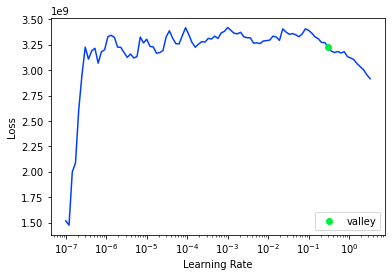

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0   5370.00    5394.63
1  27056.00   27596.51
2  14538.00   14464.62
3   8000.00    7982.01
4 261593.00  261636.59
XGBoost RMSE:  1446.154


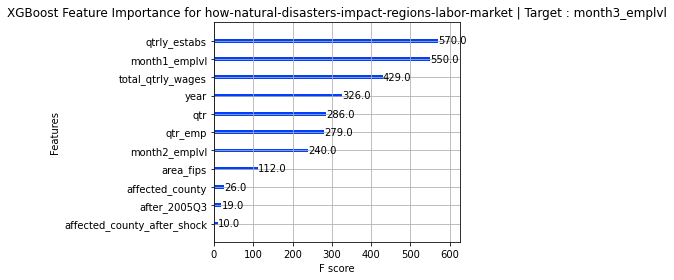

Target Variable: month2_emplvl
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
11
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  2%|▏         | 1/42 [00:00<00:06,  6.83it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9938989839818696, 'Adjusted R-Squared': 0.9936239381777735, 'RMSE': 4345.054807764043, 'Time taken': 0.1462390422821045}


  7%|▋         | 3/42 [00:00<00:03, 12.93it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9959156798336164, 'Adjusted R-Squared': 0.9957315506457877, 'RMSE': 3555.118372095277, 'Time taken': 0.07556700706481934}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999614, 'Adjusted R-Squared': 0.9999999999999596, 'RMSE': 0.010928251094911436, 'Time taken': 0.02912425994873047}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9771873923096173, 'Adjusted R-Squared': 0.9761589550776738, 'RMSE': 8401.97997846899, 'Time taken': 0.040744781494140625}
{'Model': 'DummyRegressor', 'R-Squared': -0.009823989706954528, 'Adjusted R-Squared': -0.05534884170194032, 'RMSE': 55900.67, 'Time taken': 0.024692773818969727}


 14%|█▍        | 6/42 [00:00<00:01, 19.48it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.9878783310393994, 'Adjusted R-Squared': 0.9873318623567493, 'RMSE': 6124.567, 'Time taken': 0.03736448287963867}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed -68.39503479003906 but the user-supplied value was -68.39500427246094.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9984596163604471, 'Adjusted R-Squared': 0.9983901728357132, 'RMSE': 2183.27592074244, 'Time taken': 0.030532360076904297}


 21%|██▏       | 9/42 [00:00<00:03,  9.70it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9984710485658889, 'Adjusted R-Squared': 0.9984021204274658, 'RMSE': 2175.1590654979623, 'Time taken': 0.42598533630371094}
{'Model': 'GammaRegressor', 'R-Squared': -0.7574714885532445, 'Adjusted R-Squared': -0.8367017605781861, 'RMSE': 73745.97476001145, 'Time taken': 0.03447842597961426}


 26%|██▌       | 11/42 [00:01<00:03,  8.87it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9172596451880086, 'Adjusted R-Squared': 0.913529547225173, 'RMSE': 16001.211505123081, 'Time taken': 0.23262572288513184}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9976629608783812, 'Adjusted R-Squared': 0.9975576025573246, 'RMSE': 2689.2251708679473, 'Time taken': 0.27578258514404297}


 33%|███▎      | 14/42 [00:01<00:04,  5.61it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.997277586983485, 'Adjusted R-Squared': 0.9971548552491339, 'RMSE': 2902.493010591568, 'Time taken': 0.42333006858825684}
{'Model': 'HuberRegressor', 'R-Squared': 0.9989866034365992, 'Adjusted R-Squared': 0.998940917525954, 'RMSE': 1770.8586204098483, 'Time taken': 0.14055752754211426}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9919895427618427, 'Adjusted R-Squared': 0.99162841559127, 'RMSE': 4978.779, 'Time taken': 0.034882545471191406}


 43%|████▎     | 18/42 [00:02<00:02,  8.60it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.7466832915663991, 'Adjusted R-Squared': 0.7352632760222613, 'RMSE': 27997.941, 'Time taken': 0.09717965126037598}
{'Model': 'Lars', 'R-Squared': 0.9999985501294769, 'Adjusted R-Squared': 0.9999984847664616, 'RMSE': 66.9821, 'Time taken': 0.06278562545776367}
{'Model': 'LarsCV', 'R-Squared': 0.9997595677593483, 'Adjusted R-Squared': 0.9997487286009582, 'RMSE': 862.56244, 'Time taken': 0.06367230415344238}
{'Model': 'Lasso', 'R-Squared': 0.999825008369459, 'Adjusted R-Squared': 0.9998171194025084, 'RMSE': 735.8729, 'Time taken': 0.036379098892211914}


 57%|█████▋    | 24/42 [00:02<00:01, 13.84it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed -68.39503479003906 but the user-supplied value was -68.39500427246094.
{'Model': 'LassoLars', 'R-Squared': 0.9990350904917346, 'Adjusted R-Squared': 0.9989915904729193, 'RMSE': 1727.9751, 'Time taken': 0.05461907386779785}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999994601676535, 'Adjusted R-Squared': 0.9999994358309494, 'RMSE': 40.871788, 'Time taken': 0.039919376373291016}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999994601676535, 'Adjusted R-Squared': 0.9999994358309494, 'RMSE': 40.871788, 'Time taken': 0.03973245620727539}
{'Model': 'LinearRegression', 'R-Squared': 0.999999999999661, 'Adjusted R-Squared': 0.9999999999996457, 'RMSE': 0.032387994, 'Time taken': 0.05267643928527832}
{'Model': 'LinearSVR', 'R-Squared': -0.3351543752192221, 'Adjusted R-Squared': -0.39534576098

 67%|██████▋   | 28/42 [00:04<00:03,  3.88it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.30092057405792927, 'Adjusted R-Squared': -0.35956863272447537, 'RMSE': 63448.24, 'Time taken': 1.9928600788116455}
{'Model': 'NuSVR', 'R-Squared': -0.11121623137456815, 'Adjusted R-Squared': -0.16131204508407748, 'RMSE': 58639.93288162004, 'Time taken': 0.16337227821350098}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9990045240736823, 'Adjusted R-Squared': 0.9989596460606106, 'RMSE': 1755.1310818759923, 'Time taken': 0.022423744201660156}


 71%|███████▏  | 30/42 [00:04<00:02,  4.81it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9990059323870201, 'Adjusted R-Squared': 0.9989611178634841, 'RMSE': 1753.88913856078, 'Time taken': 0.04043245315551758}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.998306596722796, 'Adjusted R-Squared': 0.9982302547717745, 'RMSE': 2289.150647652538, 'Time taken': 0.11545538902282715}
{'Model': 'PoissonRegressor', 'R-Squared': 0.751425815671878, 'Adjusted R-Squared': 0.7402196024439709, 'RMSE': 27734.617953578774, 'Time taken': 0.07747316360473633}


 76%|███████▌  | 32/42 [00:45<00:58,  5.89s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.18272845297514007, 'Adjusted R-Squared': -0.23604817831418345, 'RMSE': 60497.3983781934, 'Time taken': 40.21093535423279}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999997248, 'Adjusted R-Squared': 0.9999999999997123, 'RMSE': 0.029184252, 'Time taken': 0.053862810134887695}


 81%|████████  | 34/42 [00:45<00:34,  4.29s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9967396121933292, 'Adjusted R-Squared': 0.9965926274971268, 'RMSE': 3176.3533309485165, 'Time taken': 0.6433737277984619}
{'Model': 'Ridge', 'R-Squared': 0.998455915302808, 'Adjusted R-Squared': 0.9983863049271149, 'RMSE': 2185.897, 'Time taken': 0.02004241943359375}
{'Model': 'RidgeCV', 'R-Squared': 0.9988702845698713, 'Adjusted R-Squared': 0.99881935477589, 'RMSE': 1869.7291829475878, 'Time taken': 0.055440664291381836}


 93%|█████████▎| 39/42 [00:46<00:05,  1.97s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.9983954043749326, 'Adjusted R-Squared': 0.9983230660475729, 'RMSE': 2228.3170238361363, 'Time taken': 0.12870454788208008}
{'Model': 'SVR', 'R-Squared': -0.1826504720288229, 'Adjusted R-Squared': -0.2359666818334012, 'RMSE': 60495.40395498993, 'Time taken': 0.09945940971374512}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.999999999999661, 'Adjusted R-Squared': 0.9999999999996457, 'RMSE': 0.032387994, 'Time taken': 0.014257192611694336}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9681998674253081, 'Adjusted R-Squared': 0.966766254891203, 'RMSE': 9919.93077741865, 'Time taken': 0.051392555236816406}


100%|██████████| 42/42 [00:46<00:00,  1.12s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9973976013880158, 'Adjusted R-Squared': 0.9972802801391148, 'RMSE': 2837.7954, 'Time taken': 0.5843689441680908}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9989903629281719, 'Adjusted R-Squared': 0.9989448465028026, 'RMSE': 1767.5708087608023, 'Time taken': 0.12407112121582031}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: month2_emplvl
month2_emplvl
Target Standard Deviation: 48876.515625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
BayesianRidge                                1.00       1.00     0.01   
RANSACRegressor                              1.00       1.00     0.03   
TransformedTargetRegressor                   1.00       1.00     0.03   
LinearRegression                             1.00       1.00     0.03   
LassoLarsIC                                  1.00       1.

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 64782.4375.
Better model found at epoch 1 with _rmse value: 64664.1953125.
Better model found at epoch 2 with _rmse value: 62681.4296875.
Better model found at epoch 3 with _rmse value: 29189.1015625.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

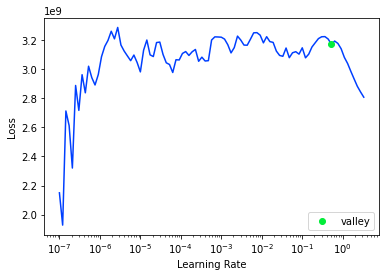

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0  13319.00   13227.81
1  36086.00   36796.01
2 247343.00  248276.00
3   3463.00    3510.31
4   4821.00    4588.52
XGBoost RMSE:  2837.2278


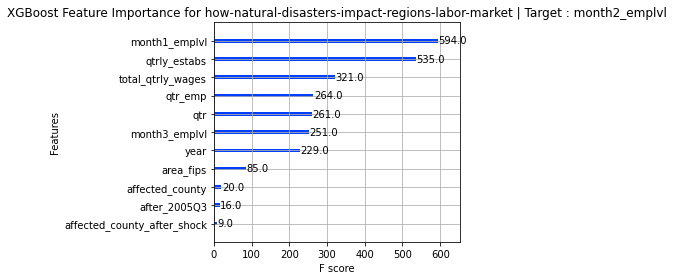

Target Variable: month1_emplvl
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
11
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  2%|▏         | 1/42 [00:00<00:06,  6.34it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.990623121251194, 'Adjusted R-Squared': 0.9902003931108789, 'RMSE': 4213.5142882576065, 'Time taken': 0.1575613021850586}


  7%|▋         | 3/42 [00:00<00:03, 10.95it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9993000725520212, 'Adjusted R-Squared': 0.9992685184457599, 'RMSE': 1151.1762824695052, 'Time taken': 0.0733637809753418}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999877, 'Adjusted R-Squared': 0.9999999999999871, 'RMSE': 0.0048395881618449295, 'Time taken': 0.06082892417907715}


 12%|█▏        | 5/42 [00:00<00:02, 14.05it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9977268624697502, 'Adjusted R-Squared': 0.9976243849581405, 'RMSE': 2074.5703998057043, 'Time taken': 0.07538270950317383}
{'Model': 'DummyRegressor', 'R-Squared': -0.012263211887849845, 'Adjusted R-Squared': -0.05789802881722017, 'RMSE': 43778.617, 'Time taken': 0.01856541633605957}
{'Model': 'ElasticNet', 'R-Squared': 0.9891002249909168, 'Adjusted R-Squared': 0.9886088416913269, 'RMSE': 4542.8047, 'Time taken': 0.018781423568725586}


 17%|█▋        | 7/42 [00:00<00:02, 12.37it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.1654837548739989, 'Adjusted R-Squared': 0.12786212087241677, 'RMSE': 39749.594, 'Time taken': 0.16720986366271973}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9990543034382267, 'Adjusted R-Squared': 0.9990116695768352, 'RMSE': 1338.108180942875, 'Time taken': 0.032640933990478516}


 21%|██▏       | 9/42 [00:01<00:04,  7.34it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9995086338639338, 'Adjusted R-Squared': 0.9994864821118981, 'RMSE': 964.5348681533471, 'Time taken': 0.41576099395751953}
{'Model': 'GammaRegressor', 'R-Squared': -0.19309375871873935, 'Adjusted R-Squared': -0.24688077243146944, 'RMSE': 47528.33579943777, 'Time taken': 0.0368647575378418}


 26%|██▌       | 11/42 [00:01<00:04,  7.13it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9622643347273471, 'Adjusted R-Squared': 0.9605631367027603, 'RMSE': 8452.619635136962, 'Time taken': 0.25269651412963867}


 29%|██▊       | 12/42 [00:01<00:05,  5.75it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9980829072389089, 'Adjusted R-Squared': 0.9979964809259089, 'RMSE': 1905.183819785261, 'Time taken': 0.30600547790527344}


 33%|███▎      | 14/42 [00:02<00:05,  4.77it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9982360898012808, 'Adjusted R-Squared': 0.9981565692595352, 'RMSE': 1827.4838871675001, 'Time taken': 0.4285140037536621}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999104966875386, 'Adjusted R-Squared': 0.9999064617021408, 'RMSE': 411.6564032163433, 'Time taken': 0.14142370223999023}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9885107035384874, 'Adjusted R-Squared': 0.9879927434521076, 'RMSE': 4664.0376, 'Time taken': 0.036588430404663086}


 43%|████▎     | 18/42 [00:02<00:02,  8.86it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.5390457280408548, 'Adjusted R-Squared': 0.5182650026656475, 'RMSE': 29542.297, 'Time taken': 0.06860852241516113}
{'Model': 'Lars', 'R-Squared': 0.999872441289878, 'Adjusted R-Squared': 0.9998666906922905, 'RMSE': 491.43985, 'Time taken': 0.03013896942138672}
{'Model': 'LarsCV', 'R-Squared': 0.9999912432527237, 'Adjusted R-Squared': 0.9999908484813301, 'RMSE': 128.7617, 'Time taken': 0.07770609855651855}
{'Model': 'Lasso', 'R-Squared': 0.9998718574272518, 'Adjusted R-Squared': 0.9998660805079885, 'RMSE': 492.5633, 'Time taken': 0.0495758056640625}


 52%|█████▏    | 22/42 [00:02<00:01, 10.36it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9998650641365704, 'Adjusted R-Squared': 0.9998589809623993, 'RMSE': 505.45096, 'Time taken': 0.17749834060668945}
{'Model': 'LassoLars', 'R-Squared': 0.9998623817018821, 'Adjusted R-Squared': 0.9998561775982785, 'RMSE': 510.45023, 'Time taken': 0.028609275817871094}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999998777187, 'Adjusted R-Squared': 0.999999999872206, 'RMSE': 0.48116636, 'Time taken': 0.08753776550292969}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999998777187, 'Adjusted R-Squared': 0.999999999872206, 'RMSE': 0.48116636, 'Time taken': 0.05706620216369629}


 57%|█████▋    | 24/42 [00:02<00:01, 11.73it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.9999999999976981, 'Adjusted R-Squared': 0.9999999999975943, 'RMSE': 0.066017695, 'Time taken': 0.05710458755493164}
{'Model': 'LinearSVR', 'R-Squared': -0.2983449976282353, 'Adjusted R-Squared': -0.3568769442426232, 'RMSE': 49580.43985996042, 'Time taken': 0.04854774475097656}


 64%|██████▍   | 27/42 [00:05<00:05,  2.90it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2726783675045359, 'Adjusted R-Squared': -0.33005321194121584, 'RMSE': 49087.92, 'Time taken': 2.0666134357452393}
{'Model': 'NuSVR', 'R-Squared': -0.04501942514311508, 'Adjusted R-Squared': -0.09213095660448523, 'RMSE': 44481.30319246175, 'Time taken': 0.13882207870483398}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9998509984812752, 'Adjusted R-Squared': 0.9998442811996934, 'RMSE': 531.1420291280679, 'Time taken': 0.019950151443481445}


 71%|███████▏  | 30/42 [00:05<00:02,  4.49it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9998585595063703, 'Adjusted R-Squared': 0.9998521830906738, 'RMSE': 517.4902867573022, 'Time taken': 0.05189228057861328}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9997760813203823, 'Adjusted R-Squared': 0.9997659866258094, 'RMSE': 651.1191719043127, 'Time taken': 0.12673711776733398}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8431599068284006, 'Adjusted R-Squared': 0.8360892468903367, 'RMSE': 17232.32459862899, 'Time taken': 0.10399556159973145}


 76%|███████▌  | 32/42 [00:49<01:07,  6.74s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.11499606995196965, 'Adjusted R-Squared': -0.16526228622029637, 'RMSE': 45946.45290047896, 'Time taken': 44.508179903030396}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999998421, 'Adjusted R-Squared': 0.999999999999835, 'RMSE': 0.01728664, 'Time taken': 0.06345200538635254}


 81%|████████  | 34/42 [00:50<00:38,  4.85s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9993231479012821, 'Adjusted R-Squared': 0.9992926340771595, 'RMSE': 1132.041142000604, 'Time taken': 0.643202543258667}
{'Model': 'Ridge', 'R-Squared': 0.9998427731784296, 'Adjusted R-Squared': 0.9998356850840145, 'RMSE': 545.6054, 'Time taken': 0.02391958236694336}
{'Model': 'RidgeCV', 'R-Squared': 0.9999153495118537, 'Adjusted R-Squared': 0.9999115333013225, 'RMSE': 400.34098583680935, 'Time taken': 0.06469345092773438}
{'Model': 'SGDRegressor', 'R-Squared': 0.9995969822126193, 'Adjusted R-Squared': 0.9995788133779423, 'RMSE': 873.5292020987151, 'Time taken': 0.11162805557250977}


 93%|█████████▎| 39/42 [00:51<00:06,  2.20s/it]

{'Model': 'SVR', 'R-Squared': -0.11322870156760079, 'Adjusted R-Squared': -0.16341524139236974, 'RMSE': 45910.02384257962, 'Time taken': 0.09852409362792969}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999976981, 'Adjusted R-Squared': 0.9999999999975943, 'RMSE': 0.066017695, 'Time taken': 0.01896524429321289}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9704487275482453, 'Adjusted R-Squared': 0.9691164980524695, 'RMSE': 7480.031277143501, 'Time taken': 0.02876877784729004}


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9989287082754436, 'Adjusted R-Squared': 0.9988804123370414, 'RMSE': 1424.1942, 'Time taken': 0.5933582782745361}
{'Model': 'LGBMRegressor', 'R-Squared': 0.999210466257297, 'Adjusted R-Squared': 0.9991748725229949, 'RMSE': 1222.6458231960805, 'Time taken': 0.1186985969543457}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: month1_emplvl
month1_emplvl
Target Standard Deviation: 51454.8125
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
BayesianRidge                                1.00       1.00     0.00   
RANSACRegressor                              1.00       1.00     0.02   
TransformedTargetRegressor                   1.00       1.00     0.07   
LinearRegression                             1.00       1.00     0.07   
LassoLarsCV                                  1.00       1.00  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 50064.87890625.
Better model found at epoch 1 with _rmse value: 49886.97265625.
Better model found at epoch 2 with _rmse value: 48412.45703125.
Better model found at epoch 3 with _rmse value: 38464.11328125.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

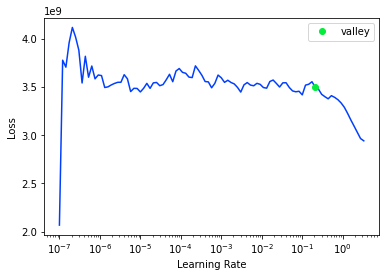

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0  2490.00    2461.21
1 37723.00   37332.24
2 32472.00   32612.11
3 10471.00   10357.69
4 13982.00   14060.79
XGBoost RMSE:  1424.1924


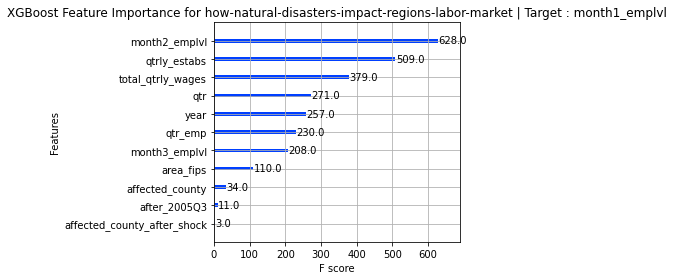

Target Variable: qtrly_estabs
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
11
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  5%|▍         | 2/42 [00:00<00:03, 12.49it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9871040319559076, 'Adjusted R-Squared': 0.9865226563473625, 'RMSE': 360.2286577858544, 'Time taken': 0.08716940879821777}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9963992319420921, 'Adjusted R-Squared': 0.9962369022345635, 'RMSE': 190.34823730550409, 'Time taken': 0.07268261909484863}
{'Model': 'BayesianRidge', 'R-Squared': 0.9640865084968746, 'Adjusted R-Squared': 0.9624674576504222, 'RMSE': 601.1461919747252, 'Time taken': 0.04647254943847656}


 10%|▉         | 4/42 [00:00<00:02, 13.39it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.989087970495548, 'Adjusted R-Squared': 0.9885960347391998, 'RMSE': 331.363029065178, 'Time taken': 0.08871054649353027}
{'Model': 'DummyRegressor', 'R-Squared': -0.005895330560394818, 'Adjusted R-Squared': -0.05124307087254376, 'RMSE': 3181.4688, 'Time taken': 0.015215873718261719}
{'Model': 'ElasticNet', 'R-Squared': 0.9481894094562627, 'Adjusted R-Squared': 0.9458536861120779, 'RMSE': 722.03876, 'Time taken': 0.02762460708618164}


 17%|█▋        | 7/42 [00:00<00:02, 13.38it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8144885261433094, 'Adjusted R-Squared': 0.8061253039612454, 'RMSE': 1366.2704, 'Time taken': 0.1788642406463623}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9862016918195616, 'Adjusted R-Squared': 0.9855796369425747, 'RMSE': 372.6183222313417, 'Time taken': 0.03429436683654785}


 21%|██▏       | 9/42 [00:00<00:04,  8.03it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9990641646005487, 'Adjusted R-Squared': 0.9990219752997538, 'RMSE': 97.0400519337087, 'Time taken': 0.3995490074157715}
{'Model': 'GammaRegressor', 'R-Squared': 0.10238070351592321, 'Adjusted R-Squared': 0.06191425982196885, 'RMSE': 3005.366048343666, 'Time taken': 0.035676002502441406}


 26%|██▌       | 11/42 [00:01<00:04,  7.68it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9314154124437706, 'Adjusted R-Squared': 0.9283234843162357, 'RMSE': 830.7389081958299, 'Time taken': 0.2464606761932373}


 29%|██▊       | 12/42 [00:01<00:04,  6.20it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9925384712916671, 'Adjusted R-Squared': 0.9922020908990783, 'RMSE': 274.00923039596665, 'Time taken': 0.2883143424987793}


 33%|███▎      | 14/42 [00:02<00:05,  5.06it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9958342436508117, 'Adjusted R-Squared': 0.9956464431596598, 'RMSE': 204.73788765474416, 'Time taken': 0.4322090148925781}
{'Model': 'HuberRegressor', 'R-Squared': 0.947787920785656, 'Adjusted R-Squared': 0.9454340975423864, 'RMSE': 724.8310344692126, 'Time taken': 0.12386417388916016}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9805681083679187, 'Adjusted R-Squared': 0.9796920804664725, 'RMSE': 442.1899, 'Time taken': 0.03441786766052246}


 43%|████▎     | 18/42 [00:02<00:02,  8.65it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.6233962273229462, 'Adjusted R-Squared': 0.6064181883907839, 'RMSE': 1946.6758, 'Time taken': 0.09190797805786133}
{'Model': 'Lars', 'R-Squared': -1.3956473164227425, 'Adjusted R-Squared': -1.5036478101958992, 'RMSE': 4909.7876, 'Time taken': 0.06201004981994629}
{'Model': 'LarsCV', 'R-Squared': 0.9390062675308031, 'Adjusted R-Squared': 0.9362565500834212, 'RMSE': 783.41864, 'Time taken': 0.06468963623046875}
{'Model': 'Lasso', 'R-Squared': 0.9629973222366394, 'Adjusted R-Squared': 0.9613291687309141, 'RMSE': 610.1939, 'Time taken': 0.04796934127807617}


 52%|█████▏    | 22/42 [00:02<00:01, 10.55it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9626040967098037, 'Adjusted R-Squared': 0.9609182158237703, 'RMSE': 613.4276, 'Time taken': 0.1820366382598877}
{'Model': 'LassoLars', 'R-Squared': 0.9625260835491788, 'Adjusted R-Squared': 0.9608366856763959, 'RMSE': 614.0671, 'Time taken': 0.029398202896118164}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9639365912298834, 'Adjusted R-Squared': 0.9623107818181158, 'RMSE': 602.3996, 'Time taken': 0.07141327857971191}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9642847380859271, 'Adjusted R-Squared': 0.962674623819309, 'RMSE': 599.4848, 'Time taken': 0.029397010803222656}
{'Model': 'LinearRegression', 'R-Squared': 0.9659880723052457, 'Adjusted R-Squared': 0.964454747696056, 'RMSE': 585.0149, 'Time taken': 0.02467489242553711}
{'Model': 'LinearSVR', 'R-Squared': 0.29422925115609677, 'Adjusted R-Squared': 0.2624117173967404, 'RMSE': 2664.9134769741922, 'Time taken': 0.032073020935058594}


 64%|██████▍   | 27/42 [00:04<00:04,  3.66it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.27802800594609944, 'Adjusted R-Squared': 0.24548008818137435, 'RMSE': 2695.327, 'Time taken': 1.9426603317260742}
{'Model': 'NuSVR', 'R-Squared': -0.09244296026577059, 'Adjusted R-Squared': -0.14169243798267028, 'RMSE': 3315.5125103829228, 'Time taken': 0.13975191116333008}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9621614133170506, 'Adjusted R-Squared': 0.9604555753928193, 'RMSE': 617.0477017260966, 'Time taken': 0.021490812301635742}


 71%|███████▏  | 30/42 [00:04<00:02,  5.50it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9640918364544312, 'Adjusted R-Squared': 0.9624730258027867, 'RMSE': 601.1015987026426, 'Time taken': 0.045287132263183594}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9546406439531557, 'Adjusted R-Squared': 0.9525957549510439, 'RMSE': 675.5923542231014, 'Time taken': 0.04382729530334473}
{'Model': 'PoissonRegressor', 'R-Squared': 0.735804698834247, 'Adjusted R-Squared': 0.7238942549292335, 'RMSE': 1630.4738218921398, 'Time taken': 0.11348700523376465}


 79%|███████▊  | 33/42 [00:47<00:43,  4.88s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.17969175344791033, 'Adjusted R-Squared': -0.23287457839843095, 'RMSE': 3445.3675381146295, 'Time taken': 41.980013370513916}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9447308708920301, 'Adjusted R-Squared': 0.9422392298256872, 'RMSE': 745.74884, 'Time taken': 0.10528945922851562}


 83%|████████▎ | 35/42 [00:47<00:24,  3.45s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9978878667218214, 'Adjusted R-Squared': 0.9977926475986248, 'RMSE': 145.78469929601022, 'Time taken': 0.6461195945739746}
{'Model': 'Ridge', 'R-Squared': 0.9640963825622031, 'Adjusted R-Squared': 0.9624777768580401, 'RMSE': 601.06354, 'Time taken': 0.017697811126708984}
{'Model': 'RidgeCV', 'R-Squared': 0.9643956764660357, 'Adjusted R-Squared': 0.9627905635198324, 'RMSE': 598.5530596626411, 'Time taken': 0.03479123115539551}
{'Model': 'SGDRegressor', 'R-Squared': 0.9635074866889356, 'Adjusted R-Squared': 0.961862332400322, 'RMSE': 605.9728595432302, 'Time taken': 0.02951216697692871}


 90%|█████████ | 38/42 [00:48<00:08,  2.09s/it]

{'Model': 'SVR', 'R-Squared': -0.14725794957592053, 'Adjusted R-Squared': -0.19897859484368752, 'RMSE': 3397.6749134574898, 'Time taken': 0.14724969863891602}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9659880723052457, 'Adjusted R-Squared': 0.964454747696056, 'RMSE': 585.0149, 'Time taken': 0.018883943557739258}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9241998002092192, 'Adjusted R-Squared': 0.9207825780875036, 'RMSE': 873.3462522633369, 'Time taken': 0.040534257888793945}


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9978373655407958, 'Adjusted R-Squared': 0.997739869725012, 'RMSE': 147.51727, 'Time taken': 0.6196668148040771}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9952030503161061, 'Adjusted R-Squared': 0.9949867943877339, 'RMSE': 219.70192760023377, 'Time taken': 0.12034273147583008}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: qtrly_estabs
qtrly_estabs
Target Standard Deviation: 2941.62158203125
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
ExtraTreesRegressor                          1.00       1.00   97.04   
RandomForestRegressor                        1.00       1.00  145.78   
XGBRegressor                                 1.00       1.00  147.52   
BaggingRegressor                             1.00       1.00  190.35   
HistGradientBoostingRegressor                1.00       1.00  2

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3755.76904296875.
Better model found at epoch 1 with _rmse value: 3536.0595703125.
Better model found at epoch 2 with _rmse value: 903.0309448242188.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

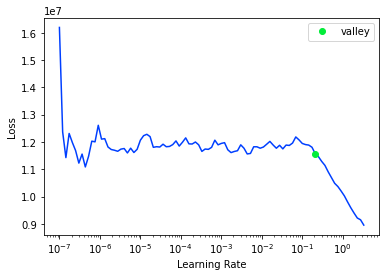

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  504.00     498.16
1 3409.00    3371.46
2 8497.00    8384.67
3  863.00     820.87
4 1700.00    1686.78
XGBoost RMSE:  147.52406


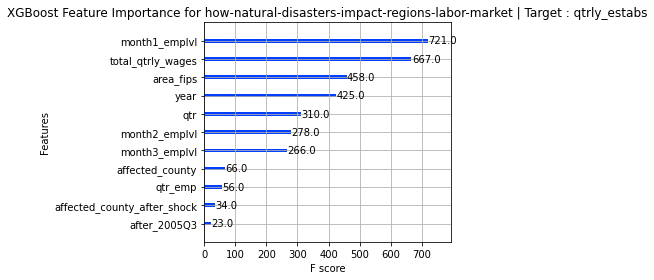

Target Variable: qtr
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  5%|▍         | 2/42 [00:00<00:02, 19.04it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.11498107333083074, 'Adjusted R-Squared': -0.16524661352197478, 'RMSE': 1.1458094629387596, 'Time taken': 0.027936220169067383}
{'Model': 'BaggingRegressor', 'R-Squared': -0.16617872693344404, 'Adjusted R-Squared': -0.2187523580656896, 'RMSE': 1.1718208320814236, 'Time taken': 0.07686376571655273}


 10%|▉         | 4/42 [00:00<00:02, 17.57it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.07579040230844125, 'Adjusted R-Squared': 0.03412521552726433, 'RMSE': 1.0431911501721332, 'Time taken': 0.03159523010253906}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.8013684428778769, 'Adjusted R-Squared': -0.8825776759584372, 'RMSE': 1.4563975247163805, 'Time taken': 0.08657193183898926}
{'Model': 'DummyRegressor', 'R-Squared': -0.0029157163591124746, 'Adjusted R-Squared': -0.04812912980153161, 'RMSE': 1.0867030237898772, 'Time taken': 0.028489351272583008}
{'Model': 'ElasticNet', 'R-Squared': -0.0029157163591124746, 'Adjusted R-Squared': -0.04812912980153161, 'RMSE': 1.0867031, 'Time taken': 0.01974940299987793}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 865.6803588867188 but the user-supplied value was 865.6806640625.


 19%|█▉        | 8/42 [00:00<00:01, 22.09it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.9008915612689197, 'Adjusted R-Squared': -0.9865874923097318, 'RMSE': 1.496088650448228, 'Time taken': 0.0712137222290039}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.21050035247771093, 'Adjusted R-Squared': -0.2650720896795751, 'RMSE': 1.1938812100665628, 'Time taken': 0.41071391105651855}
{'Model': 'GammaRegressor', 'R-Squared': 0.012863357338235848, 'Adjusted R-Squared': -0.03163870442110617, 'RMSE': 1.0781204741252024, 'Time taken': 0.030043840408325195}


 26%|██▌       | 11/42 [00:01<00:04,  7.45it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -714.3255721875382, 'Adjusted R-Squared': -746.5738561795995, 'RMSE': 29.022213486388928, 'Time taken': 0.35350680351257324}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.0827577387886611, 'Adjusted R-Squared': 0.04140665324224824, 'RMSE': 1.0392515600817707, 'Time taken': 0.30515456199645996}


 36%|███▌      | 15/42 [00:02<00:04,  5.74it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.0809696854700408, 'Adjusted R-Squared': -0.12970192538877234, 'RMSE': 1.1281982309401075, 'Time taken': 0.5742461681365967}
{'Model': 'HuberRegressor', 'R-Squared': 0.07293322474266284, 'Adjusted R-Squared': 0.031139230776143445, 'RMSE': 1.0448024092999773, 'Time taken': 0.0783843994140625}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.29539290897781467, 'Adjusted R-Squared': -0.35379176962845404, 'RMSE': 1.2350354245931572, 'Time taken': 0.03391909599304199}


 45%|████▌     | 19/42 [00:02<00:02,  8.29it/s]

{'Model': 'KernelRidge', 'R-Squared': -5.0967314930938965, 'Adjusted R-Squared': -5.37158414237272, 'RMSE': 2.679336, 'Time taken': 0.09827804565429688}
{'Model': 'Lars', 'R-Squared': -18573.72804077804, 'Adjusted R-Squared': -19411.11332130492, 'RMSE': 147.89038, 'Time taken': 0.06216001510620117}
{'Model': 'LarsCV', 'R-Squared': 0.0706187010538617, 'Adjusted R-Squared': 0.02872036380628984, 'RMSE': 1.0461059, 'Time taken': 0.06771278381347656}
{'Model': 'Lasso', 'R-Squared': -0.0029157163591124746, 'Adjusted R-Squared': -0.04812912980153161, 'RMSE': 1.0867031, 'Time taken': 0.029573917388916016}


 52%|█████▏    | 22/42 [00:02<00:01, 10.51it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 865.6803588867188 but the user-supplied value was 865.6806640625.
{'Model': 'LassoLars', 'R-Squared': -0.0029157163591124746, 'Adjusted R-Squared': -0.04812912980153161, 'RMSE': 1.0867031, 'Time taken': 0.06023097038269043}
{'Model': 'LassoLarsCV', 'R-Squared': 0.07546893018379919, 'Adjusted R-Squared': 0.033789250806839255, 'RMSE': 1.0433726, 'Time taken': 0.06338834762573242}
{'Model': 'LassoLarsIC', 'R-Squared': 0.07676043578046488, 'Adjusted R-Squared': 0.03513898001646931, 'RMSE': 1.0426435, 'Time taken': 0.05007600784301758}


 57%|█████▋    | 24/42 [00:02<00:01, 11.88it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.08351201950703668, 'Adjusted R-Squared': 0.04219493841923905, 'RMSE': 1.0388242, 'Time taken': 0.05605936050415039}
{'Model': 'LinearSVR', 'R-Squared': 0.036459606312227, 'Adjusted R-Squared': -0.006978690124517017, 'RMSE': 1.065156985609725, 'Time taken': 0.06280684471130371}


 67%|██████▋   | 28/42 [00:04<00:03,  4.03it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.049824205700014335, 'Adjusted R-Squared': 0.006988411694687002, 'RMSE': 1.0577441, 'Time taken': 1.7448575496673584}
{'Model': 'NuSVR', 'R-Squared': -0.050533124438896015, 'Adjusted R-Squared': -0.09789322431114145, 'RMSE': 1.1122016430999626, 'Time taken': 0.15002226829528809}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.00986383909543842, 'Adjusted R-Squared': -0.03477344684698047, 'RMSE': 1.079757222789769, 'Time taken': 0.018553733825683594}


 74%|███████▍  | 31/42 [00:04<00:01,  5.88it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.07060821667694483, 'Adjusted R-Squared': 0.02870940677303646, 'RMSE': 1.0461117286271402, 'Time taken': 0.04331207275390625}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.6454258397517498, 'Adjusted R-Squared': -1.7646868407241652, 'RMSE': 1.7649258035597328, 'Time taken': 0.02917027473449707}
{'Model': 'PoissonRegressor', 'R-Squared': 0.027934444591958374, 'Adjusted R-Squared': -0.01588818290594518, 'RMSE': 1.0698587283680399, 'Time taken': 0.044875383377075195}


 76%|███████▌  | 32/42 [00:21<00:26,  2.69s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.25399129172882384, 'Adjusted R-Squared': -0.31052368602807423, 'RMSE': 1.2151388809522892, 'Time taken': 16.716495752334595}


 79%|███████▊  | 33/42 [00:21<00:20,  2.25s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -1.7594599547915095, 'Adjusted R-Squared': -1.8838618379993237, 'RMSE': 1.802564, 'Time taken': 0.21656203269958496}


 83%|████████▎ | 35/42 [00:22<00:11,  1.61s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.13406891975948598, 'Adjusted R-Squared': -0.1851949776174957, 'RMSE': 1.1555756479456463, 'Time taken': 0.6658999919891357}
{'Model': 'Ridge', 'R-Squared': 0.08203873554872554, 'Adjusted R-Squared': 0.04065523592182374, 'RMSE': 1.0396588, 'Time taken': 0.019955158233642578}
{'Model': 'RidgeCV', 'R-Squared': 0.08203896722880843, 'Adjusted R-Squared': 0.04065547804650049, 'RMSE': 1.0396586707303832, 'Time taken': 0.04837226867675781}
{'Model': 'SGDRegressor', 'R-Squared': 0.07398442335751165, 'Adjusted R-Squared': 0.03223781949248139, 'RMSE': 1.0442098919162106, 'Time taken': 0.04248237609863281}


 90%|█████████ | 38/42 [00:22<00:03,  1.04it/s]

{'Model': 'SVR', 'R-Squared': -0.027834227817495005, 'Adjusted R-Squared': -0.07417101677648064, 'RMSE': 1.100120341513359, 'Time taken': 0.14936351776123047}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.08351201950703668, 'Adjusted R-Squared': 0.04219493841923905, 'RMSE': 1.0388242, 'Time taken': 0.02117753028869629}
{'Model': 'TweedieRegressor', 'R-Squared': 0.012456249627538774, 'Adjusted R-Squared': -0.03206416534826895, 'RMSE': 1.0783427665086995, 'Time taken': 0.0487060546875}


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.13783531741138844, 'Adjusted R-Squared': -0.18913117188485273, 'RMSE': 1.157493, 'Time taken': 0.6212997436523438}
{'Model': 'LGBMRegressor', 'R-Squared': -0.10392449115292157, 'Adjusted R-Squared': -0.153691578868832, 'RMSE': 1.140114164380022, 'Time taken': 0.13883304595947266}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: qtr
qtr
Target Standard Deviation: 1.12580673114813
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LinearRegression                             0.04       0.08   1.04   
TransformedTargetRegressor                   0.04       0.08   1.04   
GradientBoostingRegressor                    0.04       0.08   1.04   
RidgeCV                                      0.04       0.08   1.04   
Ridge                                        0.04       0.08   1.04   
LassoLarsIC

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.482725143432617.
Better model found at epoch 1 with _rmse value: 1.53932523727417.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.36
1       2       2.07
2       2       1.72
3       1       0.97
4       2       1.48
XGBoost RMSE:  1.157493


<Figure size 432x288 with 0 Axes>

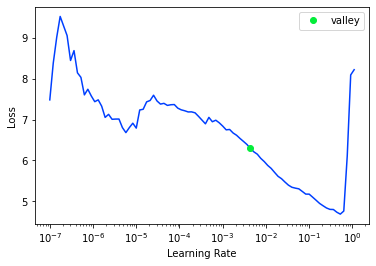

<Figure size 720x720 with 0 Axes>

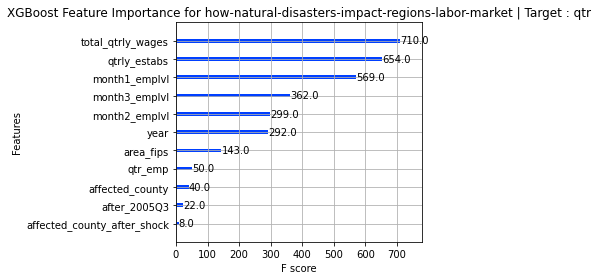

Target Variable: year
CATS=====================
['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
CONTS=====================
['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['area_fips', 'qtrly_estabs', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'qtr_emp']
Categorical variables that made the cut : ['year', 'qtr', 'affected_county', 'after_2005Q3', 'affected_county_after_shock']
Tabular Object size: 1280


  5%|▍         | 2/42 [00:00<00:02, 19.98it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7283810964845685, 'Adjusted R-Squared': 0.7161359819818236, 'RMSE': 0.7384399207150918, 'Time taken': 0.029151439666748047}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7361157728322996, 'Adjusted R-Squared': 0.7242193527550671, 'RMSE': 0.7278500017173868, 'Time taken': 0.0707101821899414}


 10%|▉         | 4/42 [00:00<00:02, 17.38it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.7239604962245167, 'Adjusted R-Squared': 0.711516092365786, 'RMSE': 0.7444247266965519, 'Time taken': 0.035063743591308594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6478170983825855, 'Adjusted R-Squared': 0.6319400003588496, 'RMSE': 0.8408515029421069, 'Time taken': 0.08878374099731445}
{'Model': 'DummyRegressor', 'R-Squared': -0.0001900158093153248, 'Adjusted R-Squared': -0.045280549308915674, 'RMSE': 1.4170214638817447, 'Time taken': 0.024131059646606445}
{'Model': 'ElasticNet', 'R-Squared': 0.4540599495712516, 'Adjusted R-Squared': 0.4294478981174965, 'RMSE': 1.0469059, 'Time taken': 0.023125886917114258}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 842.88134765625 but the user-supplied value was 842.8812255859375.


 19%|█▉        | 8/42 [00:00<00:01, 22.26it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.44934938586890427, 'Adjusted R-Squared': 0.4245249729367646, 'RMSE': 1.0514127400787951, 'Time taken': 0.07133007049560547}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6355554906968259, 'Adjusted R-Squared': 0.6191256152774205, 'RMSE': 0.8553638206196238, 'Time taken': 0.34790492057800293}
{'Model': 'GammaRegressor', 'R-Squared': 0.5401221099809722, 'Adjusted R-Squared': 0.5193899100210979, 'RMSE': 0.9608518622442985, 'Time taken': 0.02534627914428711}


 26%|██▌       | 11/42 [00:01<00:03,  9.03it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -120.51255013215435, 'Adjusted R-Squared': -125.9905749331941, 'RMSE': 15.618730771489773, 'Time taken': 0.24968695640563965}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7359058814875146, 'Adjusted R-Squared': 0.7239999990955582, 'RMSE': 0.7281394071348543, 'Time taken': 0.3004474639892578}


 36%|███▌      | 15/42 [00:01<00:04,  6.49it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7281203444461691, 'Adjusted R-Squared': 0.7158634747285784, 'RMSE': 0.7387942839841443, 'Time taken': 0.44678759574890137}
{'Model': 'HuberRegressor', 'R-Squared': 0.7257231720689201, 'Adjusted R-Squared': 0.713358233104814, 'RMSE': 0.742044123663935, 'Time taken': 0.11917304992675781}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6299160890186063, 'Adjusted R-Squared': 0.6132319782776419, 'RMSE': 0.8619563504029656, 'Time taken': 0.034322500228881836}


 45%|████▌     | 19/42 [00:02<00:02,  9.17it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.478385416388323, 'Adjusted R-Squared': -3.680279840897633, 'RMSE': 2.9984438, 'Time taken': 0.09688568115234375}
{'Model': 'Lars', 'R-Squared': 0.727336474890121, 'Adjusted R-Squared': 0.7150442667909052, 'RMSE': 0.73985857, 'Time taken': 0.05386948585510254}
{'Model': 'LarsCV', 'R-Squared': 0.7253167783018613, 'Adjusted R-Squared': 0.712933518307273, 'RMSE': 0.74259365, 'Time taken': 0.06411981582641602}
{'Model': 'Lasso', 'R-Squared': 0.22871123106972835, 'Adjusted R-Squared': 0.1939400160769701, 'RMSE': 1.2443532, 'Time taken': 0.032967567443847656}


 50%|█████     | 21/42 [00:02<00:01, 10.89it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 842.88134765625 but the user-supplied value was 842.8812255859375.
{'Model': 'LassoLars', 'R-Squared': -0.0001900158093153248, 'Adjusted R-Squared': -0.045280549308915674, 'RMSE': 1.4170215, 'Time taken': 0.05603170394897461}
{'Model': 'LassoLarsCV', 'R-Squared': 0.7253167783018613, 'Adjusted R-Squared': 0.712933518307273, 'RMSE': 0.74259365, 'Time taken': 0.0312654972076416}
{'Model': 'LassoLarsIC', 'R-Squared': 0.7242685858871293, 'Adjusted R-Squared': 0.711838071316467, 'RMSE': 0.7440092, 'Time taken': 0.025554895401000977}
{'Model': 'LinearRegression', 'R-Squared': 0.7273502099609558, 'Adjusted R-Squared': 0.715058621065753, 'RMSE': 0.73983985, 'Time taken': 0.024023771286010742}


 60%|█████▉    | 25/42 [00:02<00:01, 14.24it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.6964463610529288, 'Adjusted R-Squared': 0.6827615658544952, 'RMSE': 0.7806437605741066, 'Time taken': 0.08727741241455078}


 64%|██████▍   | 27/42 [00:04<00:05,  2.90it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7127092182119074, 'Adjusted R-Squared': 0.6997575846067065, 'RMSE': 0.7594445, 'Time taken': 2.200361967086792}
{'Model': 'NuSVR', 'R-Squared': 0.65474139004642, 'Adjusted R-Squared': 0.639176452712447, 'RMSE': 0.8325444499512333, 'Time taken': 0.16658329963684082}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7091555833887687, 'Adjusted R-Squared': 0.6960437449349837, 'RMSE': 0.7641269844008839, 'Time taken': 0.019581317901611328}


 74%|███████▍  | 31/42 [00:04<00:02,  4.62it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7261965152184389, 'Adjusted R-Squared': 0.71385291549468, 'RMSE': 0.7414035424342647, 'Time taken': 0.04784584045410156}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4201441264352812, 'Adjusted R-Squared': 0.3940030829549045, 'RMSE': 1.0789348009802446, 'Time taken': 0.0283660888671875}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6717223561554433, 'Adjusted R-Squared': 0.6569229541788444, 'RMSE': 0.811812669815215, 'Time taken': 0.036324501037597656}


 79%|███████▊  | 33/42 [00:22<00:18,  2.02s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.00012161011758404783, 'Adjusted R-Squared': -0.045209059754032666, 'RMSE': 1.4169730060940615, 'Time taken': 16.889747619628906}
{'Model': 'RANSACRegressor', 'R-Squared': -0.40485297291414235, 'Adjusted R-Squared': -0.46818650857830457, 'RMSE': 1.6793864, 'Time taken': 0.18244028091430664}


 88%|████████▊ | 37/42 [00:22<00:05,  1.06s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7221882038185578, 'Adjusted R-Squared': 0.7096639015316895, 'RMSE': 0.7468106666853386, 'Time taken': 0.613170862197876}
{'Model': 'Ridge', 'R-Squared': 0.7244472463061434, 'Adjusted R-Squared': 0.7120247860986335, 'RMSE': 0.7437681, 'Time taken': 0.015992403030395508}
{'Model': 'RidgeCV', 'R-Squared': 0.7257834060343142, 'Adjusted R-Squared': 0.7134211825358612, 'RMSE': 0.7419626389927544, 'Time taken': 0.0395810604095459}
{'Model': 'SGDRegressor', 'R-Squared': 0.7221391703260736, 'Adjusted R-Squared': 0.7096126575129047, 'RMSE': 0.7468765694296888, 'Time taken': 0.06301045417785645}


 93%|█████████▎| 39/42 [00:22<00:02,  1.32it/s]

{'Model': 'SVR', 'R-Squared': 0.7154981018410467, 'Adjusted R-Squared': 0.7026721965961757, 'RMSE': 0.7557493029610038, 'Time taken': 0.12175750732421875}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.7273502099609558, 'Adjusted R-Squared': 0.715058621065753, 'RMSE': 0.73983985, 'Time taken': 0.018915653228759766}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5472071064626975, 'Adjusted R-Squared': 0.5267943120819174, 'RMSE': 0.9534215680460251, 'Time taken': 0.028061389923095703}


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.7375357912362923, 'Adjusted R-Squared': 0.7257033883821907, 'RMSE': 0.72588897, 'Time taken': 0.6118156909942627}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7454850527322241, 'Adjusted R-Squared': 0.7340110182242505, 'RMSE': 0.7148119718658771, 'Time taken': 0.1255505084991455}
Project: how-natural-disasters-impact-regions-labor-market
how-natural-disasters-impact-regions-labor-market
Target: year
year
Target Standard Deviation: 1.413517462294307
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.73       0.75  0.71        0.13
XGBRegressor                                 0.73       0.74  0.73        0.61
BaggingRegressor                             0.72       0.74  0.73        0.07
GradientBoostingRegressor                    0.72       0.74  0.73        0.30
AdaBoostRegressor                  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.3143439292907715.
Better model found at epoch 1 with _rmse value: 1.9936765432357788.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.85
1       2       1.64
2       1       1.97
3       2       1.61
4       5       4.57
XGBoost RMSE:  0.7257693


<Figure size 432x288 with 0 Axes>

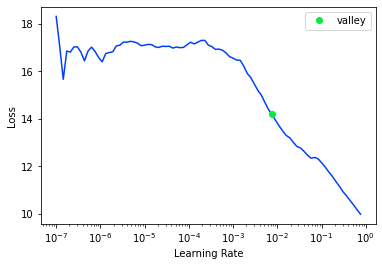

<Figure size 720x720 with 0 Axes>

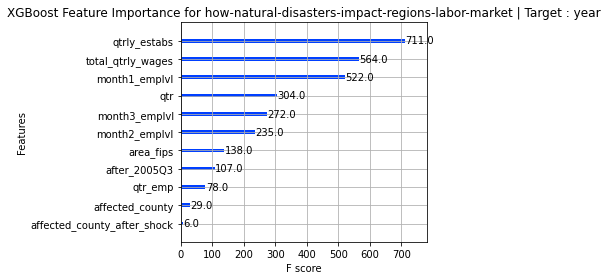

<Figure size 432x288 with 0 Axes>

In [20]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

                       feature  importance
0                         year      257.00
1                          qtr      271.00
2              affected_county       34.00
3                 after_2005Q3       11.00
4  affected_county_after_shock        3.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

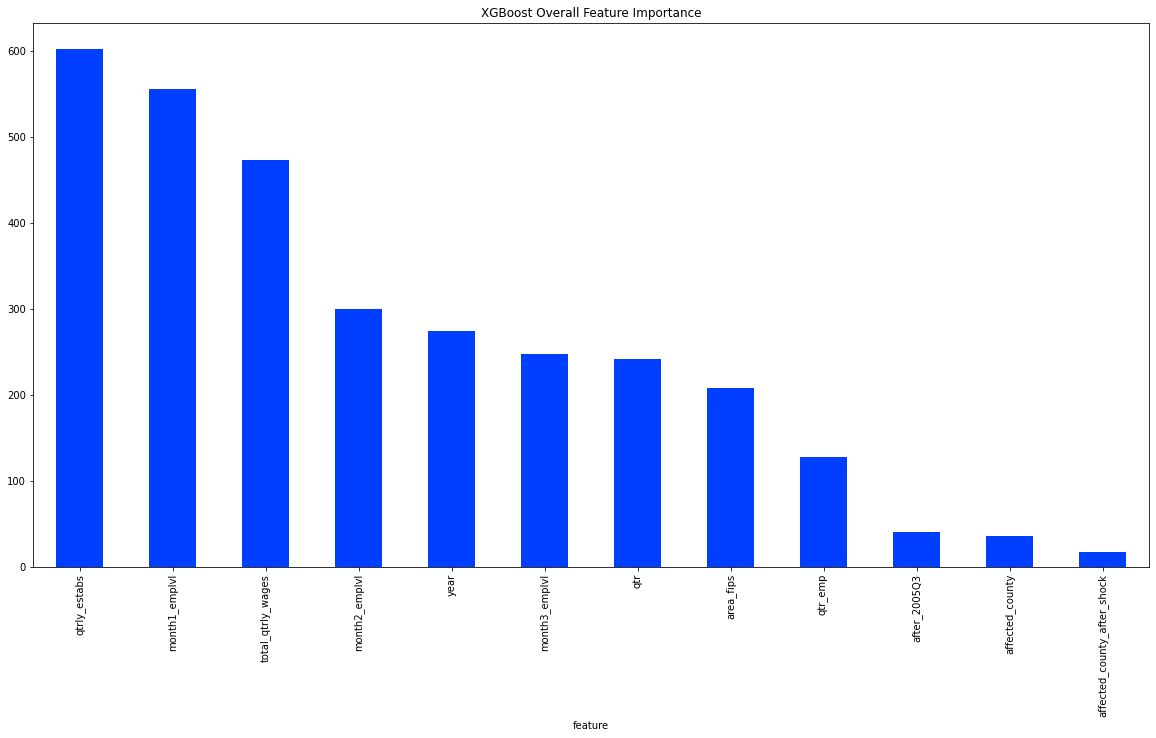

In [21]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [22]:
df.isna().sum()

area_fips                      0
year                           0
qtr                            0
qtrly_estabs                   0
month1_emplvl                  0
month2_emplvl                  0
month3_emplvl                  0
total_qtrly_wages              0
qtr_emp                        0
affected_county                0
after_2005Q3                   0
affected_county_after_shock    0
dtype: int64

# **To Be Continued...**